In [1]:
# !pip install nltk
# !pip install pandarallel
# !pip install ipywidgets
# !pip install matplotlib
# !pip install seaborn
# !pip install textstat
# !pip install spacy
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# !pip install transformers

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from scipy.stats import ttest_ind
import textstat
import spacy
import re

from tqdm import tqdm
tqdm.pandas()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

/users/eleves-a/2021/abasse.dabere/Desktop/ChatGPT-Generated-Abstracts-Detection/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [5]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=28) # !nproc --all

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
# Download NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download the English model for spaCy
spacy.cli.download("en_core_web_sm")

# Stop words list
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     /users/eleves-a/2021/abasse.dabere/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-a/2021/abasse.dabere/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /users/eleves-a/2021/abasse.dabere/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.0 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
import sys
sys.path.append("../scripts/")
from utils import get_statistics_df, kdeplot_comparison, histplot_comparison, compare_groups

In [8]:
# Load the dataset
train_test_path = '../data/train_test/'
train_data = pd.read_csv(f'{train_test_path}train.csv')
test_data = pd.read_csv(f'{train_test_path}test.csv')

In [9]:
train_data.head(5)

,abstract,label
0,Automated seizure detection using clinical ele...,human
1,This research work aims to propose a systemati...,human
2,this paper first analyses the new challenges o...,human
3,Accurate network traffic identification is an ...,human
4,The combinatorial explosion problem is a great...,human


## `Data overview`

In [10]:
# Number of samples per label
for label in train_data['label'].unique():
    print(f'Label {label}: {len(train_data[train_data["label"] == label])} samples')

Label human: 12316 samples
Label generation: 12316 samples
Label polish: 12316 samples
Label mix: 3611 samples


In [11]:
# Check if there are any missing values
for label in train_data['label'].unique():
    print(f'Label {label}: {train_data[train_data["label"] == label].isnull().sum().sum()}')

Label human: 0
Label generation: 0
Label polish: 0
Label mix: 0


In [12]:
# Print some samples
for label in train_data['label'].unique():
    print(f"\nSamples from {label}:")
    sample = train_data[train_data['label'] == label].sample(1)['abstract'].values[0]
    sample = sent_tokenize(sample)
    for sent in sample:
        print(sent)


Samples from human:
We present an approach that combines automatic features learned by convolutional neural networks (CNN) and handcrafted features computed by the bag-of-visual-words (BOVW) model in order to achieve the state-of-the-art results in facial expression recognition (FER).
To obtain automatic features, we experiment with multiple CNN architectures, pre-trained models, and training procedures, e.g., Dense-Sparse-Dense.
After fusing the two types of features, we employ a local learning framework to predict the class label for each test image.
The local learning framework is based on three steps.
First, a k-nearest neighbors model is applied in order to select the nearest training samples for an input test image.
Second, a one-versus-all support vector machines (SVM) classifier is trained on the selected training samples.
Finally, the SVM classifier is used to predict the class label only for the test image it was trained for.
Although we have used local learning in combinati

## `Descriptive statistics and basic distributions`

#### Number of characters

In [13]:
# Count the number of characters in the text
def count_characters(text):
    return len(text)

train_data['num_characters'] = train_data['abstract'].parallel_apply(count_characters)

In [14]:
# Statistics of characters count
statistics = get_statistics_df(train_data, 'num_characters')
print(statistics)

              count         mean  median         std    min     max
label                                                              
generation  12316.0   928.307324   922.0  155.271671  377.0  2245.0
human       12316.0  1083.809272  1057.0  352.440387  300.0  3868.0
mix          3611.0   994.170036   970.0  319.444305  290.0  2283.0
polish      12316.0  1111.873823  1087.0  339.397444  217.0  3924.0


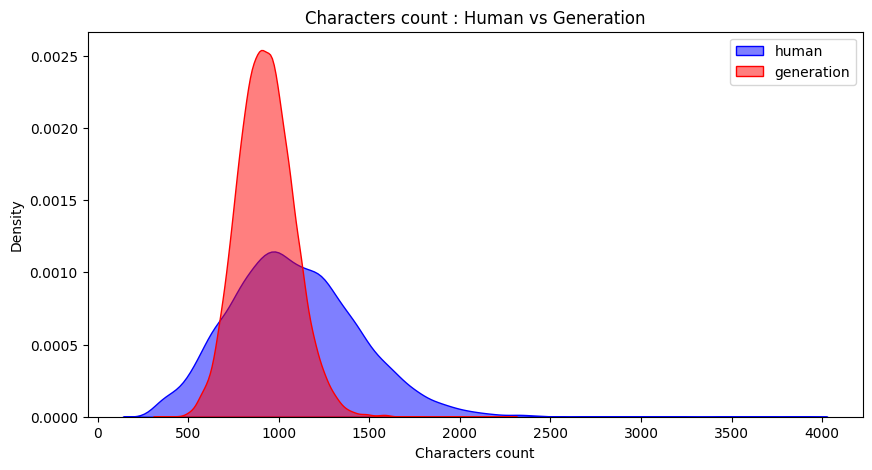

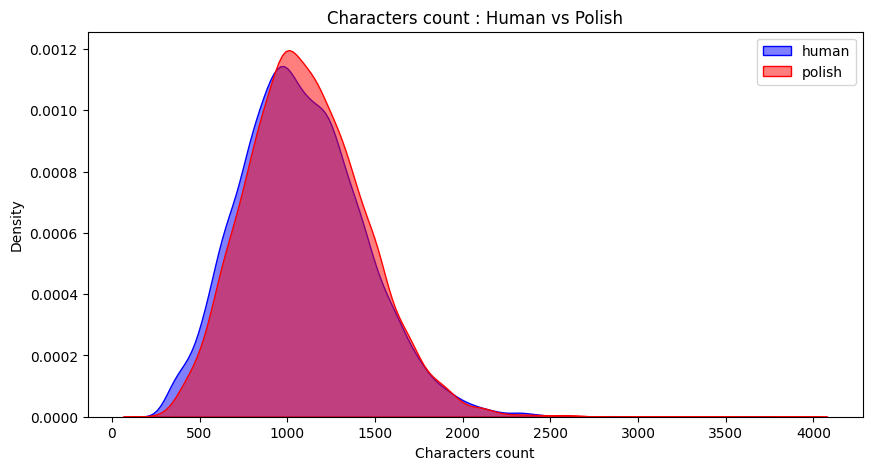

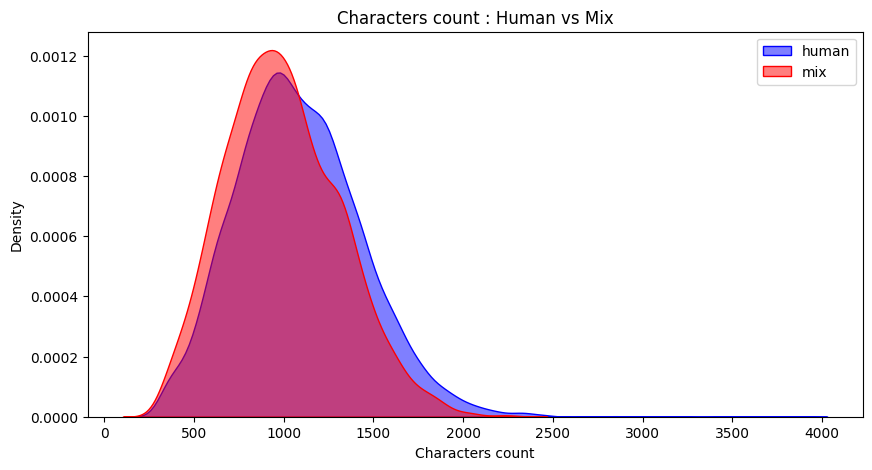

In [15]:
# Plot distribution comparison distribution
kdeplot_comparison(train_data, 'num_characters', 'Characters count')

In [17]:
# Welch t-test to check if the means are significantly different
for label in train_data['label'].unique():
    if label == 'human': continue
    print(f'\nWelch t-test between human and {label}:')
    t_stat, df, p_value = compare_groups(statistics, 'human', label)
    print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
    if p_value < 0.01:
        print(f'The means are significantly different at the 1% level.')
    elif p_value < 0.05:
        print(f'The means are significantly different at the 5% level.')
    else:
        print(f'The means are not significantly different.')


Welch t-test between human and generation:
T-statistic: 44.80904277856376, Degrees of freedom: 16921.98875526217, P-value: 0.0
The means are significantly different at the 1% level.

Welch t-test between human and polish:
T-statistic: -6.3654110283616685, Degrees of freedom: 24595.058479394494, P-value: 1.9820270821171412e-10
The means are significantly different at the 1% level.

Welch t-test between human and mix:
T-statistic: 14.475841995251063, Degrees of freedom: 6407.351788429013, P-value: 9.35970064035754e-47
The means are significantly different at the 1% level.


**Human vs Generation**  
- **Averages**:  
  - Human = 1,083.8 characters  
  - Generation = 928.3 characters  
- **Standard deviation**:  
  - Human = 352.4  
  - Generation = 155.3  
- **Extremes (min / max)**:  
  - Human: 300 / 3,868  
  - Generation: 377 / 2,245  
- **Interpretation**:  
  1. **Average length difference**: Generated abstracts are, on average, 155 characters shorter than human-written ones. This shortening is **highly significant** (p ≈ 0) and corresponds to a **medium effect size** (Cohen’s d ≈ 0.57), meaning length alone offers a moderately strong signal to distinguish between generated and human texts.  
  2. **Homogeneity**: The lower dispersion (σ ≈ 155 vs 352) shows that ChatGPT produces **highly standardized** summaries around ~900–1,000 characters, whereas human abstracts vary much more widely (range 300–3,868).  
  3. **Asymmetry**: The right-skewed tail in human abstracts (a few very long examples) disappears entirely in generated ones – a strong sign of **automated uniformity**.  
  4. **Use in classification**: In practice, a simple length threshold (e.g., flagging any abstract <1,000 characters) could already yield a non-trivial accuracy for filtering generated content, even before applying finer features.  

---

**Human vs Polish**  
- **Averages**:  
  - Human = 1,083.8 characters  
  - Polish = 1,111.9 characters  
- **Standard deviation**:  
  - Human = 352.4  
  - Polish = 339.4  
- **Extremes (min / max)**:  
  - Human: 300 / 3,868  
  - Polish: 217 / 3,924  
- **Interpretation**:  
  1. **Slight increase**: After polishing, abstracts gain on average 28 characters (negligible effect size, d ≈ 0.08), suggesting that ChatGPT adds a few details or reformulates slightly without drastically altering the original structure.  
  2. **Wider range**: A lower minimum (217) and a slightly higher maximum (3,924) indicate that polishing can **trim** some abstracts and **expand** others, slightly increasing upper-end variance.  
  3. **Substantial overlap**: The distributions overlap almost entirely, making length a **very weak discriminator** for “human vs polish.” Additional features (style, vocabulary, syntax) will be essential for separation.  
  4. **Use in classification**: Length alone is insufficient; combining it with lexical richness or readability metrics is better suited to capture the subtle differences introduced by polishing.  

---

**Human vs Mix**  
- **Averages**:  
  - Human = 1,083.8 characters  
  - Mix = 994.2 characters  
- **Standard deviation**:  
  - Human = 352.4  
  - Mix = 319.4  
- **Extremes (min / max)**:  
  - Human: 300 / 3,868  
  - Mix: 290 / 2,283  
- **Interpretation**:  
  1. **Moderate decrease**: Mix shortens abstracts by 90 characters on average (small effect size, d ≈ 0.27). This reflects **compression**, as the AI partially replaces or reformulates content without generating something as short as a fully generated abstract.  
  2. **Truncated upper tail**: The maximum of 2,283 (vs 3,868 for humans) shows that mix removes very long human passages, while maintaining more variability than pure generation.  
  3. **Reduced dispersion**: A lower σ (319 vs 352) confirms a trend toward more homogeneous abstracts, though less strictly than in full generation.  
  4. **Use in classification**: Length remains a **weak but usable signal**; for this comparison, combining length with lexical/syntactic features will be more effective, as mix includes human fragments that blur simple length-based boundaries.


In [18]:
test_data['num_characters'] = test_data['abstract'].parallel_apply(count_characters)

#### Number of words

In [19]:
# Count the number of words in each sample
def count_words(text):
    words = word_tokenize(text)
    return len(words)

train_data['word_count'] = train_data['abstract'].parallel_apply(count_words)

In [20]:
# Statistics of word count
statistics = get_statistics_df(train_data, 'word_count')
print(statistics)

              count        mean  median        std   min    max
label                                                          
generation  12316.0  145.257957   144.0  25.408621  56.0  387.0
human       12316.0  178.263154   174.0  58.886415  44.0  650.0
mix          3611.0  160.876212   156.0  52.040959  43.0  382.0
polish      12316.0  178.497402   174.0  55.317389  39.0  634.0


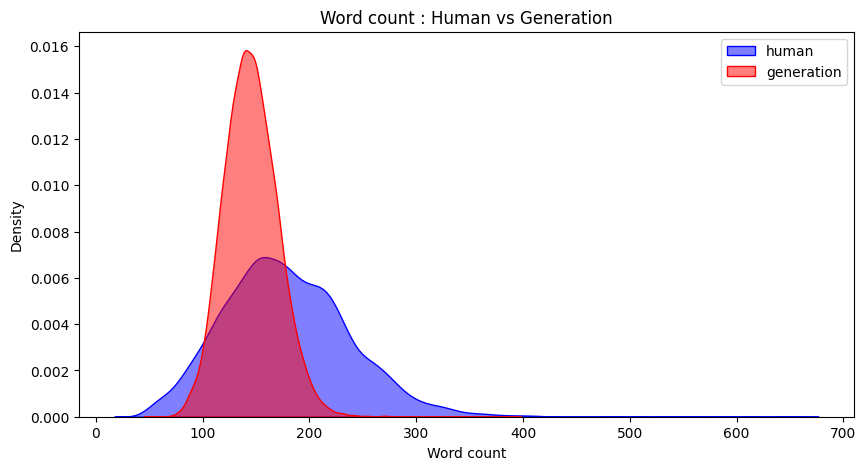

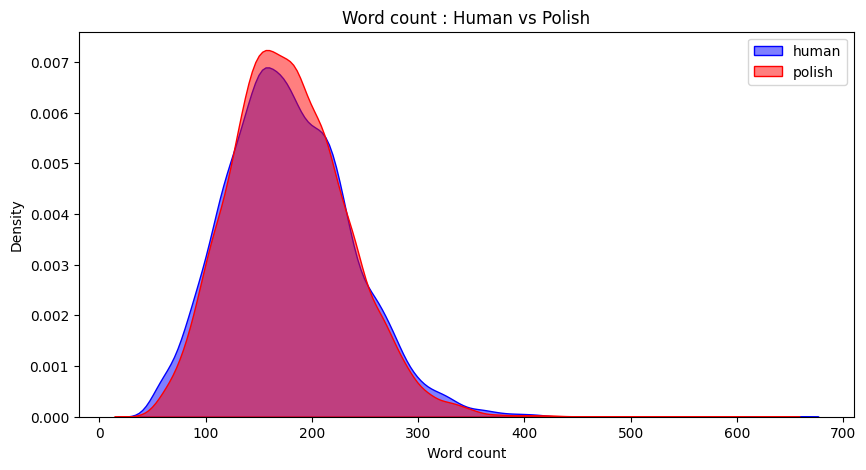

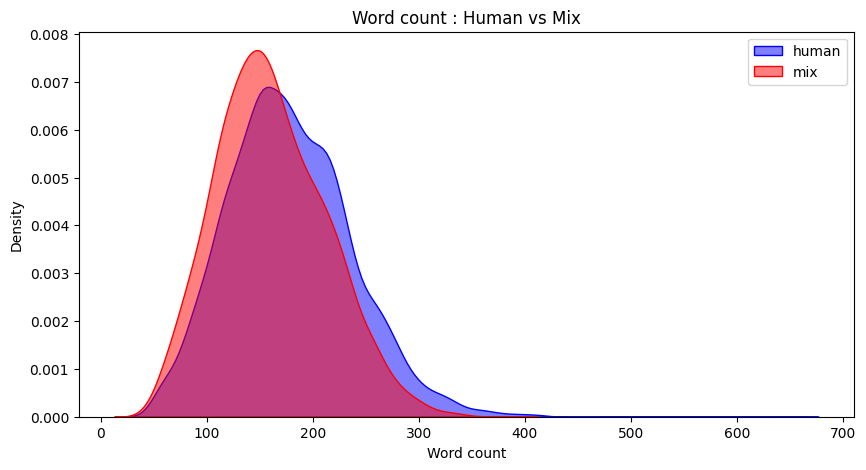

In [21]:
# Plot the distribution of word counts
kdeplot_comparison(train_data, 'word_count', 'Word count')

In [22]:
# Welch t-test to check if the means are significantly different
for label in train_data['label'].unique():
    if label == 'human': continue
    print(f'\nWelch t-test between human and {label}:')
    t_stat, df, p_value = compare_groups(statistics, 'human', label)
    print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
    if p_value < 0.01:
        print(f'The means are significantly different at the 1% level.')
    elif p_value < 0.05:
        print(f'The means are significantly different at the 5% level.')
    else:
        print(f'The means are not significantly different.')


Welch t-test between human and generation:
T-statistic: 57.11192923190384, Degrees of freedom: 16746.97716576938, P-value: 0.0
The means are significantly different at the 1% level.

Welch t-test between human and polish:
T-statistic: -0.32176101981461663, Degrees of freedom: 24534.341226216246, P-value: 0.7476364879743488
The means are not significantly different.

Welch t-test between human and mix:
T-statistic: 17.118933874805364, Degrees of freedom: 6558.227087985687, P-value: 2.6338508292835037e-64
The means are significantly different at the 1% level.


**Human vs Generation**  
- **Averages**  
  - Human: 178.26 words  
  - Generation: 145.26 words  
- **Standard deviation**  
  - Human: 58.89  
  - Generation: 25.41  
- **Extremes (min / max)**  
  - Human: 44 / 650  
  - Generation: 56 / 387  
- **Interpretation**  
  1. **Strong and significant difference** (p ≈ 0): Generated abstracts contain on average **33 fewer words** than human-written ones, with a substantial effect size (Cohen’s d ≈ 0.61).  
  2. **Marked uniformity**: The standard deviation is nearly **2× lower**, showing that generation is highly standardized around 140–150 words, whereas human abstracts range more widely, from ~50 to 650 words.  
  3. **Truncated upper tail**: Very long abstracts (over 300 words) are nearly absent in generated texts, a clear sign of an internal length constraint.  
  4. **Use in classification**: A simple **threshold around 170 words** can already isolate most generated abstracts. Combined with local variance metrics (e.g., word dispersion per sentence), this becomes a highly effective first-line filter.  

---

**Human vs Polish**  
- **Averages**  
  - Human: 178.26 words  
  - Polish: 178.50 words  
- **Standard deviation**  
  - Human: 58.89  
  - Polish: 55.32  
- **Extremes (min / max)**  
  - Human: 44 / 650  
  - Polish: 39 / 634  
- **Interpretation**  
  1. **No significant difference** (p ≈ 0.75): Length remains virtually unchanged after polishing, with an average variation of **–0.23 words** (negligible effect, d ≈ 0.00).  
  2. **Near-complete overlap** of distributions: Word count alone does not distinguish human from polish.  
  3. **Similar min/max values**: Extremes shift slightly in both directions (some abstracts gained or lost a sentence), but with no systematic trend.  
  4. **Use in classification**: Word count is a **non-discriminative feature** here; stylistic or lexical features are needed to detect polish edits.  

---

**Human vs Mix**  
- **Averages**  
  - Human: 178.26 words  
  - Mix: 160.88 words  
- **Standard deviation**  
  - Human: 58.89  
  - Mix: 52.04  
- **Extremes (min / max)**  
  - Human: 44 / 650  
  - Mix: 43 / 382  
- **Interpretation**  
  1. **Moderate but significant difference** (p ≈ 2.6×10⁻⁶⁴): Mix shortens abstracts by **17.4 words** on average (small-to-moderate effect size, d ≈ 0.30).  
  2. **Reduction of upper tail**: Many human abstracts exceed 300 words, while mix rarely goes beyond 380 words.  
  3. **Slightly reduced dispersion**: σ drops by ~12%, indicating that mix tends to **smooth out** both very short and very long passages.  
  4. **Use in classification**: While word count alone is **less effective** (weaker than in generation), **combining it** with sentence-length variance or lexical indicators (e.g., rare token TF–IDF) can help detect the “mixed” nature of these abstracts.


In [23]:
test_data['word_count'] = test_data['abstract'].parallel_apply(count_words)

#### Number of sentences

In [24]:
# Count the number of sentences in each sample
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

train_data['sentence_count'] = train_data['abstract'].parallel_apply(count_sentences)

In [25]:
# Statistics of sentence count
statistics = get_statistics_df(train_data, 'sentence_count')
print(statistics)

              count      mean  median       std  min   max
label                                                     
generation  12316.0  6.256577     6.0  1.163500  3.0  15.0
human       12316.0  7.145015     7.0  2.496656  1.0  31.0
mix          3611.0  6.509831     6.0  2.077208  1.0  16.0
polish      12316.0  7.400455     7.0  2.391196  1.0  28.0


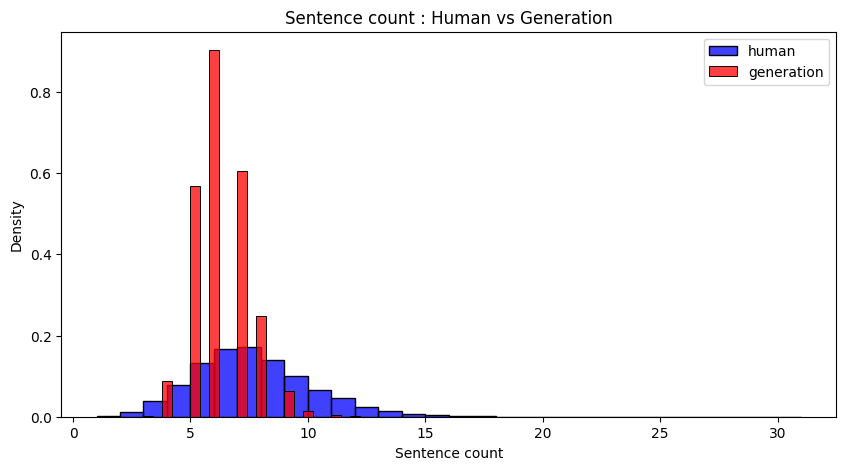

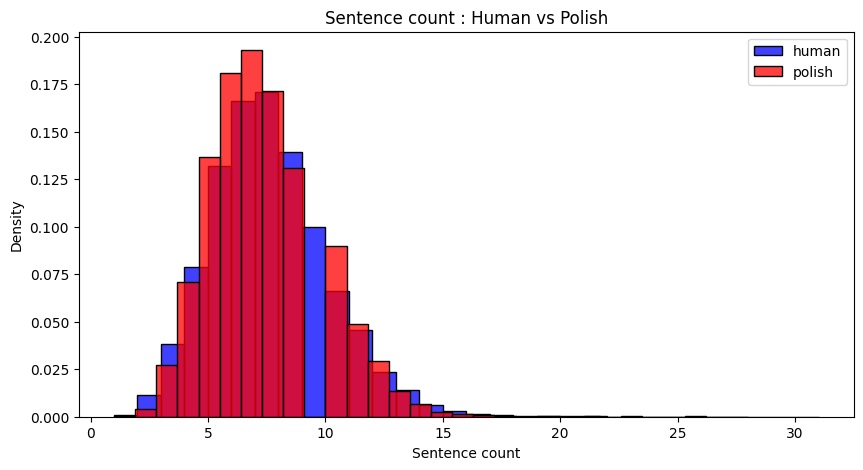

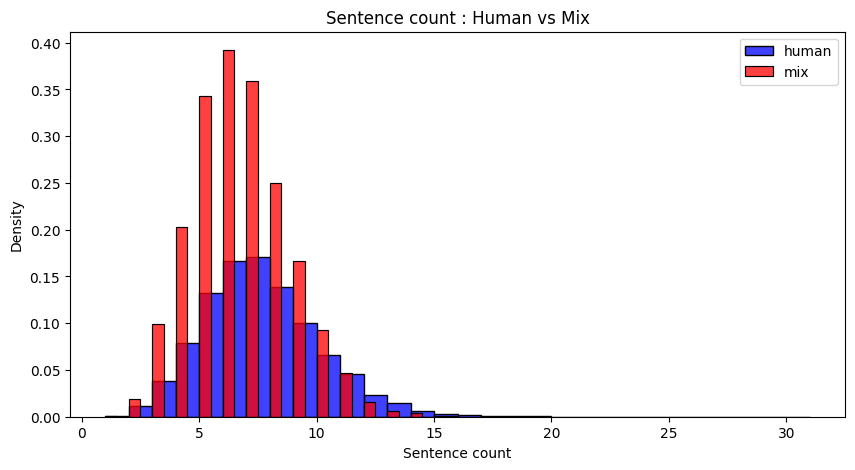

In [26]:
# Plot the distribution of sentence counts
histplot_comparison(train_data, 'sentence_count', 'Sentence count')

In [27]:
# Welch t-test to check if the means are significantly different
for label in train_data['label'].unique():
    if label == 'human': continue
    print(f'\nWelch t-test between human and {label}:')
    t_stat, df, p_value = compare_groups(statistics, 'human', label)
    print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
    if p_value < 0.01:
        print(f'The means are significantly different at the 1% level.')
    elif p_value < 0.05:
        print(f'The means are significantly different at the 5% level.')
    else:
        print(f'The means are not significantly different.')


Welch t-test between human and generation:
T-statistic: 35.795307161902905, Degrees of freedom: 17423.15603655955, P-value: 7.704077715618621e-271
The means are significantly different at the 1% level.

Welch t-test between human and polish:
T-statistic: -8.200110312146736, Degrees of freedom: 24584.264666761883, P-value: 2.5178732475830296e-16
The means are significantly different at the 1% level.

Welch t-test between human and mix:
T-statistic: 15.400863130021646, Degrees of freedom: 6950.239753670117, P-value: 1.1878888492536908e-52
The means are significantly different at the 1% level.


**Human vs Generation**  
- **Averages**  
  - Human: 7.15 sentences  
  - Generation: 6.26 sentences  
- **Standard deviation**  
  - Human: 2.50  
  - Generation: 1.16  
- **Extremes (min / max)**  
  - Human: 1 / 31  
  - Generation: 3 / 15  
- **Interpretation**  
  1. **Reduction in sentence count**: Generated abstracts contain on average **0.89 fewer sentences** than human ones (medium effect size, d ≈ 0.38). This reflects a more condensed style — ChatGPT tends to compose **fewer, longer sentences** rather than breaking content into multiple segments.  
  2. **Greatly reduced dispersion**: σ drops from 2.50 to 1.16, a **~54% reduction**. Generated texts mostly fall between 5 and 8 sentences, while human ones range from 1 to 31 — a sign of a **highly constrained algorithmic mode**.  
  3. **Clipped extremes**: Very short (<3 sentences) and very long (>15 sentences) abstracts are nearly absent in generation, whereas humans occasionally produce highly concise or extensive texts.  
  4. **Use in classification**: A simple rule — flag any abstract with fewer than 5 or more than 10 sentences — can eliminate a substantial portion of generated content before applying more sophisticated models.  

---

**Human vs Polish**  
- **Averages**  
  - Human: 7.15 sentences  
  - Polish: 7.40 sentences  
- **Standard deviation**  
  - Human: 2.50  
  - Polish: 2.39  
- **Extremes (min / max)**  
  - Human: 1 / 31  
  - Polish: 1 / 28  
- **Interpretation**  
  1. **Slight increase**: Polishing adds an average of **0.25 sentences** (d ≈ 0.10), suggesting that ChatGPT tends to **slightly break down or clarify** ideas without drastically altering the original structure.  
  2. **Nearly stable dispersion**: Variance remains very close (σ from 2.50 to 2.39), and the min/max values are nearly identical — indicating that polishing **respects the human layout** while subtly refining content.  
  3. **Maximum overlap**: The distributions overlap almost perfectly, meaning **sentence count alone is insufficient** to detect polishing.  
  4. **Use in classification**: Should be avoided as a standalone feature. Better combined with structural similarity metrics (e.g., pre/post sentence alignment) or semantic features to detect polishing edits.  

---

**Human vs Mix**  
- **Averages**  
  - Human: 7.15 sentences  
  - Mix: 6.51 sentences  
- **Standard deviation**  
  - Human: 2.50  
  - Mix: 2.08  
- **Extremes (min / max)**  
  - Human: 1 / 31  
  - Mix: 1 / 16  
- **Interpretation**  
  1. **Moderate decrease**: Mix reduces the number of sentences by **0.64 on average** (d ≈ 0.25), placing its effect between pure generation and polish — the AI reworks some human phrasing but doesn’t rewrite segmentation entirely.  
  2. **Reduction of extremes**: The max drops from 31 to 16 sentences, showing that mix **clips overly long abstracts**, while maintaining more variability than generation.  
  3. **Intermediate dispersion**: σ decreases by ~17%, suggesting a **partial smoothing effect**: mix standardizes more than polish, but less than generation.  
  4. **Use in classification**: Sentence count becomes a **weak to moderate signal**; when combined with features like average words per sentence or detection of “glued” segments lacking fine punctuation, it can help identify hybrid abstracts.

In [28]:
test_data['sentence_count'] = test_data['abstract'].parallel_apply(count_sentences)

#### mean sentence lengths

In [29]:
def get_mean_var_sentence_length(text):
    sentences = sent_tokenize(text)
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    return np.mean(sentence_lengths), np.var(sentence_lengths)

train_data['mean_sentence_length'], train_data['burstiness'] = zip(*train_data['abstract'].parallel_apply(get_mean_var_sentence_length))

In [30]:
# Statistics of mean sentence length
statistics = get_statistics_df(train_data, 'mean_sentence_length')
print(statistics)

              count       mean     median       std        min    max
label                                                                
generation  12316.0  23.464469  23.200000  3.183343  13.125000   48.8
human       12316.0  25.786044  24.833333  6.554608   9.833333  155.0
mix          3611.0  25.071219  24.500000  4.628670  11.000000   63.0
polish      12316.0  24.491425  24.000000  3.853717  12.333333   52.0


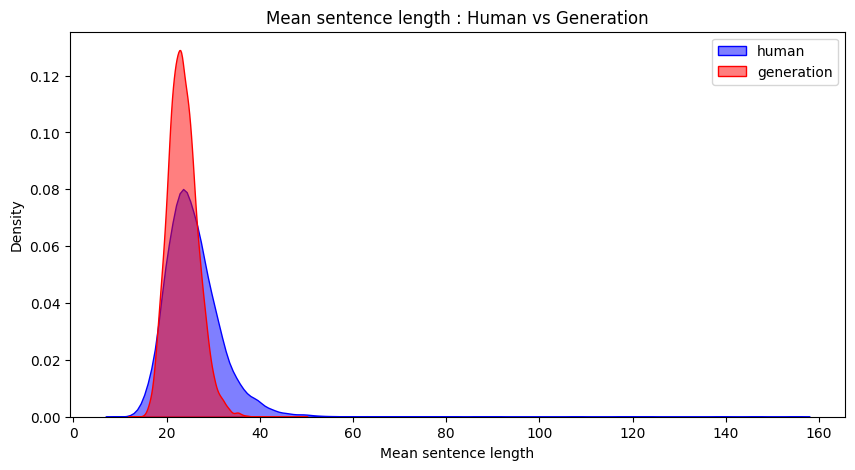

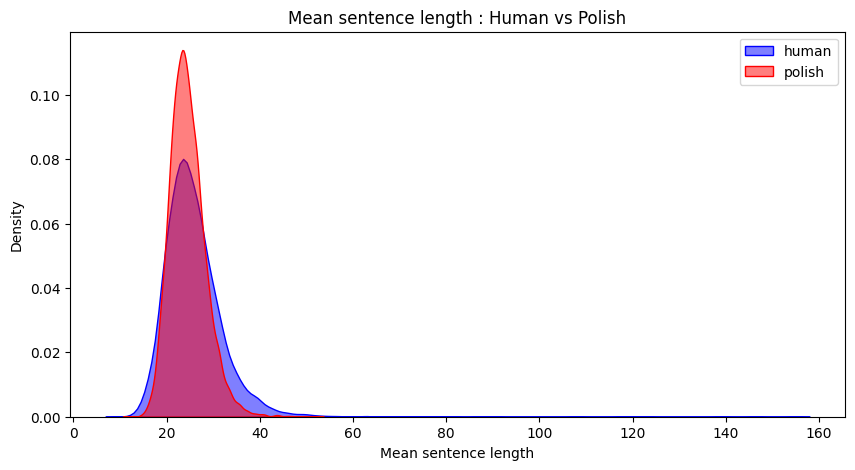

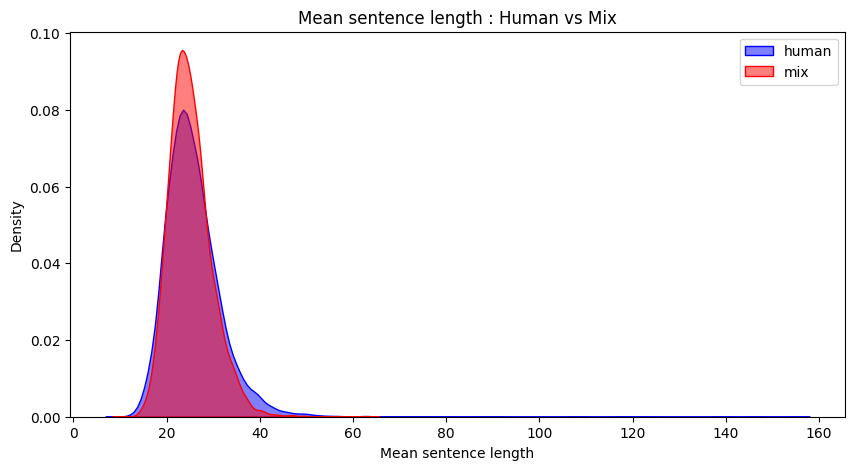

In [31]:
# Kdeplot comparison
kdeplot_comparison(train_data, 'mean_sentence_length', 'Mean sentence length')

In [32]:
# Welch t-test to check if the means are significantly different
for label in train_data['label'].unique():
    if label == 'human': continue
    print(f'\nWelch t-test between human and {label}:')
    t_stat, df, p_value = compare_groups(statistics, 'human', label)
    print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
    if p_value < 0.01:
        print(f'The means are significantly different at the 1% level.')
    elif p_value < 0.05:
        print(f'The means are significantly different at the 5% level.')
    else:
        print(f'The means are not significantly different.')


Welch t-test between human and generation:
T-statistic: 35.357724885273136, Degrees of freedom: 17818.3124674812, P-value: 9.93911061760057e-265
The means are significantly different at the 1% level.

Welch t-test between human and polish:
T-statistic: 18.895577430583753, Degrees of freedom: 19920.193710931224, P-value: 6.081089085681509e-79
The means are significantly different at the 1% level.

Welch t-test between human and mix:
T-statistic: 7.364428777176477, Degrees of freedom: 8265.346465044584, P-value: 1.9501681189097016e-13
The means are significantly different at the 1% level.


#### Human vs Generation  
- **Averages**  
  - Human: 25.79 words/sentence  
  - Generation: 23.46 words/sentence  
- **Standard Deviation**  
  - Human: 6.55  
  - Generation: 3.18  
- **Extreme Values (min / max)**  
  - Human: 9.83 / 155.0  
  - Generation: 13.13 / 48.8  
- **Interpretation**  
  1. **More concise phrasing**: Generated texts have **2.33 fewer words** per sentence on average (medium effect size, d ≈ 0.45), reflecting a more direct, compressed style.  
  2. **High uniformity**: σ is halved; generated sentences vary little around ~23 words, while human writing shows broad variability (up to 155 words).  
  3. **Trimming of extremes**: No very long (> 50 words) or very short (< 13 words) sentences in generation, suggesting a consistent algorithmic pattern.  
  4. **Classification Use**: a simple threshold on average sentence length (e.g., flag < 24 words) captures a significant portion of generated texts before refinement.

#### Human vs Polish  
- **Averages**  
  - Human: 25.79 words/sentence  
  - Polish: 24.49 words/sentence  
- **Standard Deviation**  
  - Human: 6.55  
  - Polish: 3.85  
- **Extreme Values (min / max)**  
  - Human: 9.83 / 155.0  
  - Polish: 12.33 / 52.0  
- **Interpretation**  
  1. **Slight shortening**: Polishing removes **1.30 words** per sentence on average (d ≈ 0.23), a small but significant effect.  
  2. **Reduced dispersion**: σ drops by ~41%, indicating that ChatGPT slightly standardizes sentence length without fundamentally altering structure.  
  3. **Moderated extremes**: very long sentences (> 50 words) are nearly eliminated, though some shorter ones (~12 words) remain.  
  4. **Classification Use**: this metric is **not very discriminative** for human vs polish — better to combine with internal structure metrics (e.g., number of clauses, use of connectors).

#### Human vs Mix  
- **Averages**  
  - Human: 25.79 words/sentence  
  - Mix: 25.07 words/sentence  
- **Standard Deviation**  
  - Human: 6.55  
  - Mix: 4.63  
- **Extreme Values (min / max)**  
  - Human: 9.83 / 155.0  
  - Mix: 11.0 / 63.0  
- **Interpretation**  
  1. **Limited decrease**: Hybrid abstracts average **0.72 fewer words** per sentence (d ≈ 0.13), a small but real effect.  
  2. **Intermediate dispersion**: Mix’s σ (4.63) falls between generation (3.18) and polish (3.85), reflecting partial homogenization.  
  3. **Trimming of very long sentences**: Sentences > 60 words disappear, though variability remains higher than in pure generation.  
  4. **Classification Use**: average sentence length is a **weak signal**, better used alongside lexical or punctuation-based features to detect mix.

#### Burstiness

In [33]:
# Statistics of burstiness
statistics = get_statistics_df(train_data, 'burstiness')
print(statistics)

              count       mean     median         std   min        max
label                                                                 
generation  12316.0  26.301213  21.888889   19.191711  0.25   313.3600
human       12316.0  89.131711  59.555556  123.263533  0.00  3170.0000
mix          3611.0  61.712867  46.400000   63.333698  0.00  1022.0000
polish      12316.0  49.744406  38.969796   50.269277  0.00  2395.1875


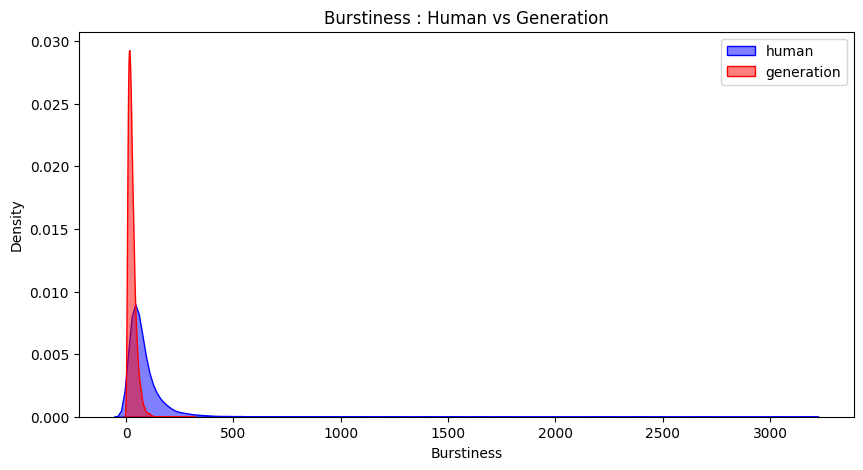

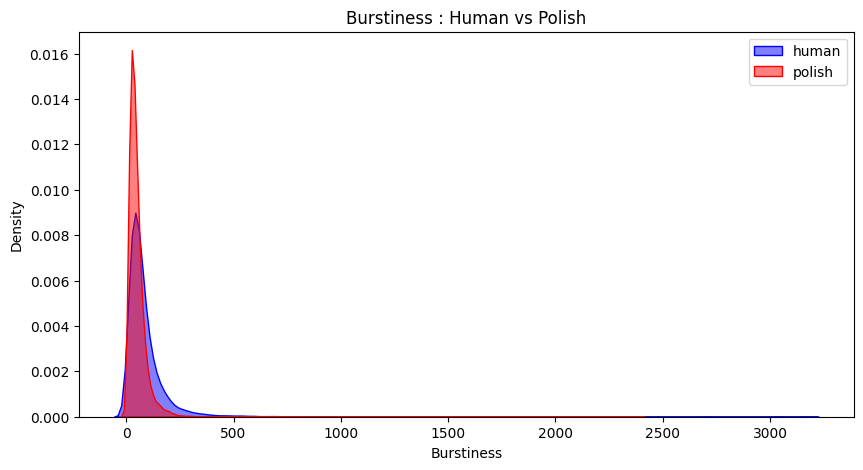

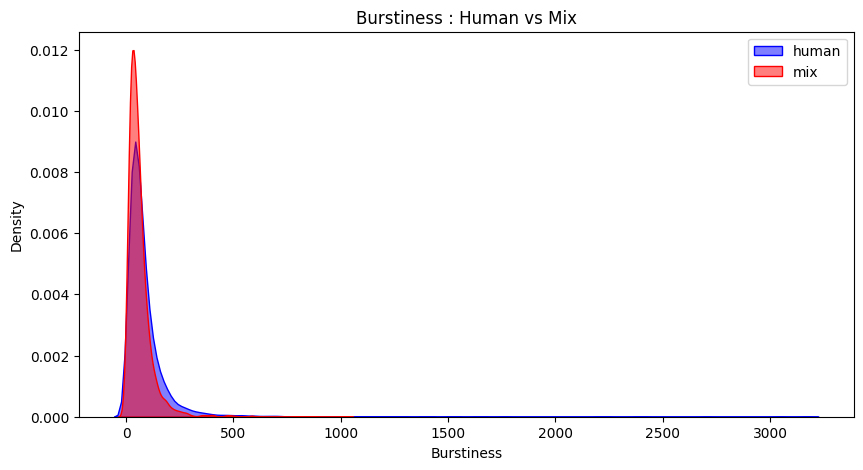

In [34]:
# Kdeplot comparison
kdeplot_comparison(train_data, 'burstiness', 'Burstiness')

In [35]:
# Welch t-test to check if the means are significantly different
for label in train_data['label'].unique():
    if label == 'human': continue
    print(f'\nWelch t-test between human and {label}:')
    t_stat, df, p_value = compare_groups(statistics, 'human', label)
    print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
    if p_value < 0.01:
        print(f'The means are significantly different at the 1% level.')
    elif p_value < 0.05:
        print(f'The means are significantly different at the 5% level.')
    else:
        print(f'The means are not significantly different.')


Welch t-test between human and generation:
T-statistic: 55.89456264192264, Degrees of freedom: 12911.71566618111, P-value: 0.0
The means are significantly different at the 1% level.

Welch t-test between human and polish:
T-statistic: 32.835847684314324, Degrees of freedom: 16301.120972440867, P-value: 4.897543610292161e-229
The means are significantly different at the 1% level.

Welch t-test between human and mix:
T-statistic: 17.907096149554558, Degrees of freedom: 11810.820165167383, P-value: 8.923477327091282e-71
The means are significantly different at the 1% level.


**Human vs Generation**  
- **Averages**  
  - Human: 89.13  
  - Generation: 26.30  
- **Standard Deviation**  
  - Human: 123.26  
  - Generation: 19.19  
- **Extreme Values (min / max)**  
  - Human: 0.00 / 3,170.00  
  - Generation: 0.25 / 313.36  
- **Interpretation**  
  1. **Large difference**: purely generated abstracts show **62.8 points lower burstiness** on average (a ~3.4× difference), reflecting highly consistent sentence lengths.  
  2. **Trimmed dispersion**: generation’s σ (19.2) is nearly 6× lower than human’s (123.3), with **virtually no extreme outliers** (max 313 vs 3,170) — the model avoids spikes in lexical intensity.  
  3. **Classification signal**: a **low threshold** (e.g., burstiness < 40) captures most generated texts, making it a **highly discriminative feature** for initial filtering.

---

**Human vs Polish**  
- **Averages**  
  - Human: 89.13  
  - Polish: 49.74  
- **Standard Deviation**  
  - Human: 123.26  
  - Polish: 50.27  
- **Extreme Values (min / max)**  
  - Human: 0.00 / 3,170.00  
  - Polish: 0.00 / 2,395.19  
- **Interpretation**  
  1. **Noticeable reduction**: polishing reduces burstiness by **39.4 points** (–44%), with d ≈ 0.66 (a medium to large effect). ChatGPT clearly smooths high lexical concentrations.  
  2. **Reduced upper tail**: extreme values > 1,000 disappear, although some outliers remain (< 2,400).  
  3. **Classification use**: an **intermediate threshold** (burstiness < 70) helps isolate many polished texts before applying finer filters.

---

**Human vs Mix**  
- **Averages**  
  - Human: 89.13  
  - Mix: 61.71  
- **Standard Deviation**  
  - Human: 123.26  
  - Mix: 63.33  
- **Extreme Values (min / max)**  
  - Human: 0.00 / 3,170.00  
  - Mix: 0.00 / 1,022.00  
- **Interpretation**  
  1. **Moderate effect**: mix reduces burstiness by **27.4 points** (–31%), d ≈ 0.27 (small to medium effect). More variability is preserved than in polish, reflecting the hybrid nature.  
  2. **Intermediate curve**: σ for mix (63.3) lies between generation and polish, and the maximum (1,022) is significantly lower than in human texts (3,170), indicating **partial trimming** of extremes.  
  3. **Classification use**: burstiness remains a **useful signal** for detecting mix, especially when combined with lexical entropy or sentence length variance to capture the human/AI duality.


In [36]:
test_data['mean_sentence_length'], test_data['burstiness'] = zip(*test_data['abstract'].parallel_apply(get_mean_var_sentence_length))

## `Stopword Analysis`

In [37]:
# Stop words ratio
def stop_words_ratio(text):
    tokens = word_tokenize(text)
    stop_words_count = sum(1 for word in tokens if word.lower() in stop_words)
    return stop_words_count / len(tokens) if len(tokens) > 0 else 0

In [38]:
train_data['stop_words_ratio'] = train_data['abstract'].parallel_apply(stop_words_ratio)

In [39]:
# Statistics of stop words ratio
statistics = get_statistics_df(train_data, 'stop_words_ratio')
print(statistics)

              count      mean    median       std       min       max
label                                                                
generation  12316.0  0.337805  0.338028  0.034536  0.204918  0.464286
human       12316.0  0.336175  0.335443  0.042865  0.164948  0.512346
mix          3611.0  0.329761  0.328671  0.041430  0.171429  0.486842
polish      12316.0  0.325007  0.325000  0.038988  0.174603  0.475000


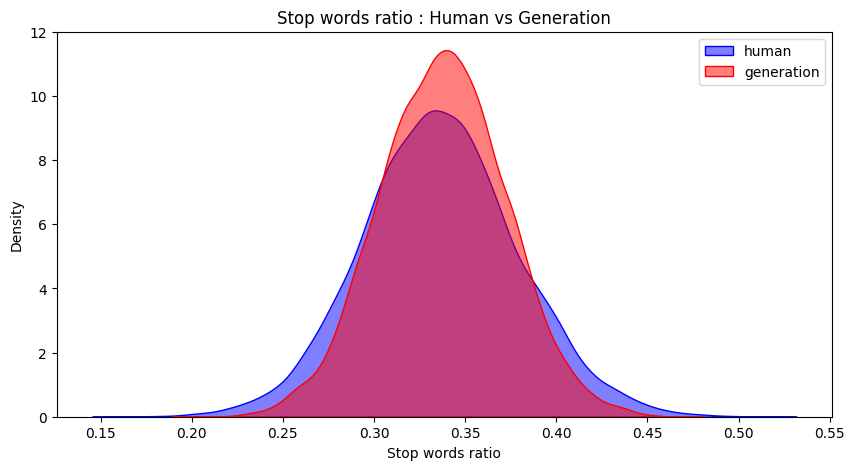

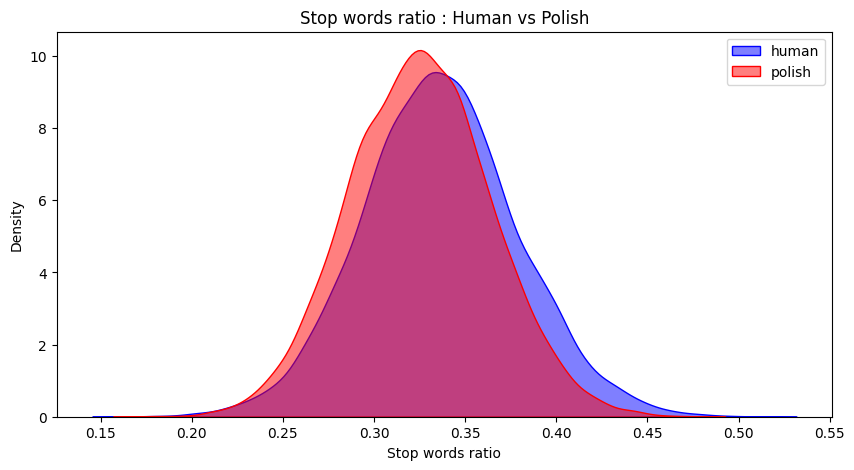

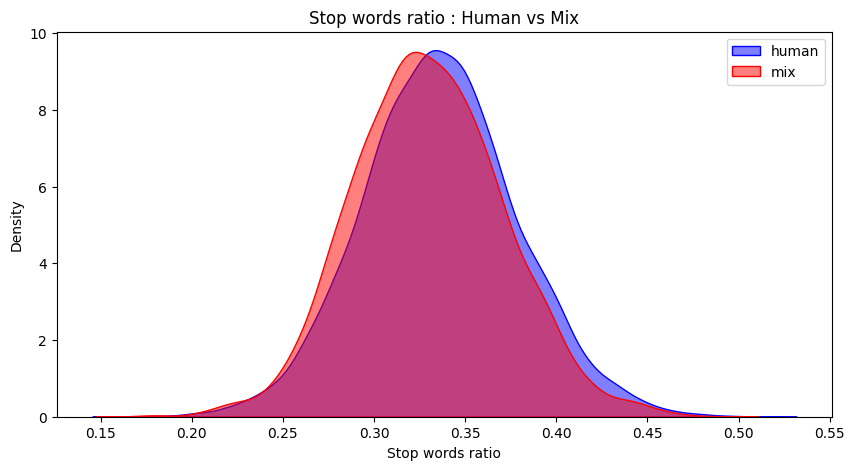

In [40]:
# Plot kdeplot comparison
kdeplot_comparison(train_data, 'stop_words_ratio', 'Stop words ratio')

In [41]:
# Welch t-test to check if the means are significantly different
for label in train_data['label'].unique():
    if label == 'human': continue
    print(f'\nWelch t-test between human and {label}:')
    t_stat, df, p_value = compare_groups(statistics, 'human', label)
    print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
    if p_value < 0.01:
        print(f'The means are significantly different at the 1% level.')
    elif p_value < 0.05:
        print(f'The means are significantly different at the 5% level.')
    else:
        print(f'The means are not significantly different.')


Welch t-test between human and generation:
T-statistic: -3.285383811964412, Degrees of freedom: 23563.440388661387, P-value: 0.0010199221055196164
The means are significantly different at the 1% level.

Welch t-test between human and polish:
T-statistic: 21.38971687135497, Degrees of freedom: 24411.836449353592, P-value: 1.3967937560762665e-100
The means are significantly different at the 1% level.

Welch t-test between human and mix:
T-statistic: 8.116604918770559, Degrees of freedom: 6056.839867548545, P-value: 5.758065521152823e-16
The means are significantly different at the 1% level.


**Human vs Generation**  
- **Averages**  
  - Human: 0.3362  
  - Generation: 0.3378  
- **Standard deviation**  
  - Human: 0.0429  
  - Generation: 0.0345  
- **Extremes (min / max)**  
  - Human: 0.1649 / 0.5123  
  - Generation: 0.2049 / 0.4643  
- **Interpretation**  
  1. **Minimal mean difference**: Generated abstracts have a stop-word ratio higher by only 0.0016 (≈0.16%), indicating a **very small effect** (Cohen’s d ≈ 0.04).  
  2. **Tighter dispersion**: Generation results in much **more homogeneous** stop-word usage (σ ≈ 0.034 vs 0.043), reflecting a more “standardized” writing style.  
  3. **Muted extremes**: Very low and very high stop-word ratios (distribution tails) are nearly absent in generated texts, signaling an **internal uniform style rule**.  
  4. **Use in classification**: Despite statistical significance (p ≈ 0.001), this is a **very weak signal** on its own. However, it can **slightly enhance** a machine-text detection model when **combined** with other lexical metrics.  

---

**Human vs Polish**  
- **Averages**  
  - Human: 0.3362  
  - Polish: 0.3250  
- **Standard deviation**  
  - Human: 0.0429  
  - Polish: 0.0390  
- **Extremes (min / max)**  
  - Human: 0.1649 / 0.5123  
  - Polish: 0.1746 / 0.4750  
- **Interpretation**  
  1. **Moderate decrease**: Polishing reduces the stop-word ratio by 0.0112 on average (≈1.1%), a **medium effect size** (Cohen’s d ≈ 0.27). This suggests ChatGPT **prunes** function words in favor of more meaningful content during polishing.  
  2. **Slightly lower dispersion**: σ drops from 0.0429 to 0.0390, indicating a subtle smoothing in stop-word usage post-polish.  
  3. **Slight attenuation of extremes**: Very high ratios (> 0.45) become less common, and very low ones (< 0.20) also decrease slightly in polish versions.  
  4. **Use in classification**: This decline in stop-word ratio provides a **useful signal** for distinguishing human from polish. When **combined with a χ² test** on specific stop-word frequencies (e.g., “however,” “therefore”), it becomes a valuable feature for a classifier.  

---

**Human vs Mix**  
- **Averages**  
  - Human: 0.3362  
  - Mix: 0.3298  
- **Standard deviation**  
  - Human: 0.0429  
  - Mix: 0.0414  
- **Extremes (min / max)**  
  - Human: 0.1649 / 0.5123  
  - Mix: 0.1714 / 0.4868  
- **Interpretation**  
  1. **Slight decrease**: Mix lowers the stop-word ratio from 0.3362 to 0.3298 (Δ ≈ 0.0064), a **small effect** (Cohen’s d ≈ 0.15) reflecting a balance between retained human segments and AI-generated insertions.  
  2. **Midway dispersion**: Mix’s σ (0.0414) sits between generation (0.0345) and polish (0.0390), consistent with its **hybrid** nature.  
  3. **Moderated extremes**: Mix retains some high or low values due to human fragments, while softening the extremes (max 0.4868 vs 0.5123).  
  4. **Use in classification**: This stop-word ratio, combined with **local variance features** (e.g., sentence-level stop-word ratio std) and **similarity metrics** (e.g., KL divergence between stop-word distributions), can help detect hybrid abstracts.

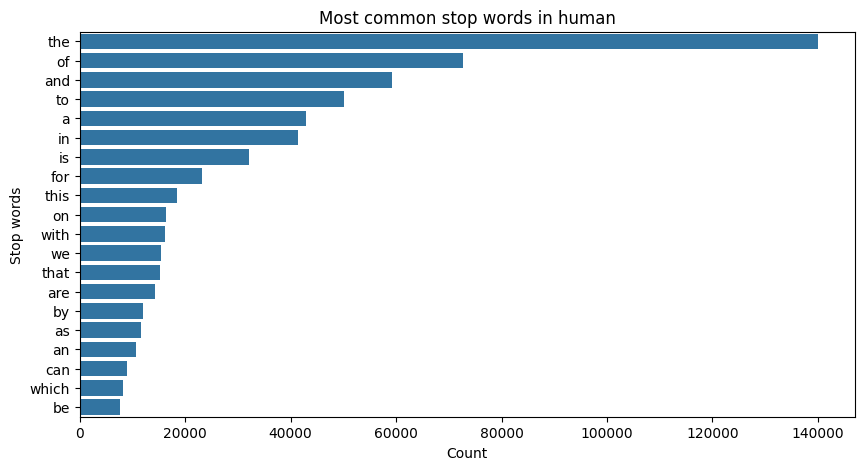

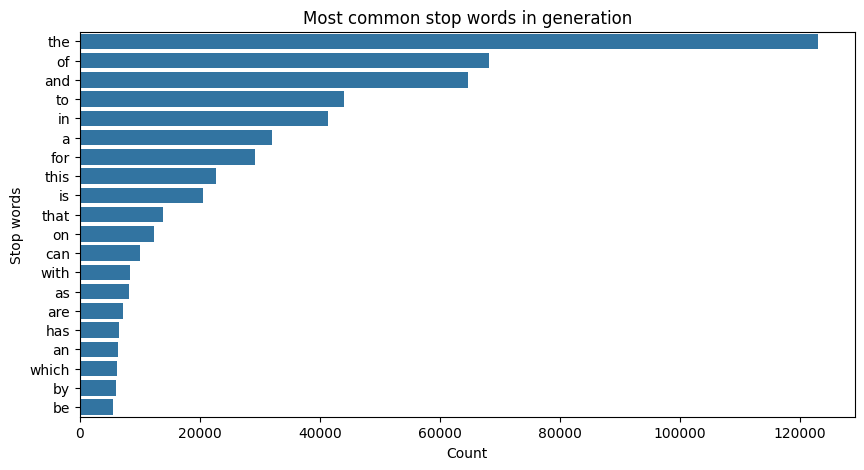

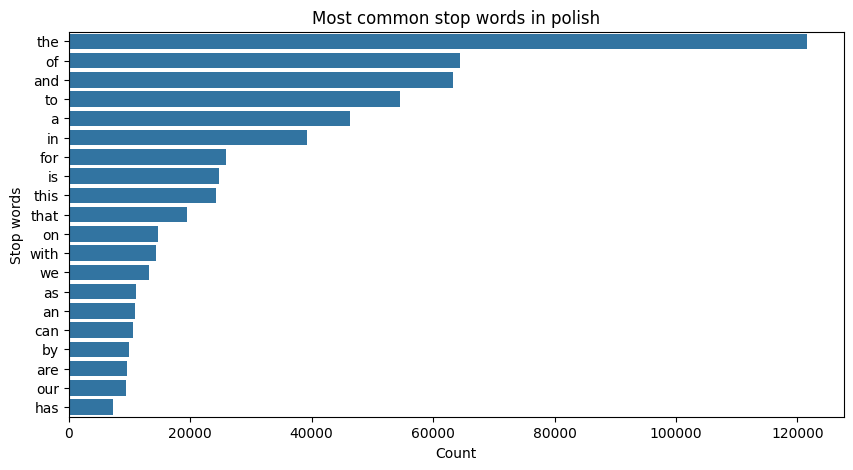

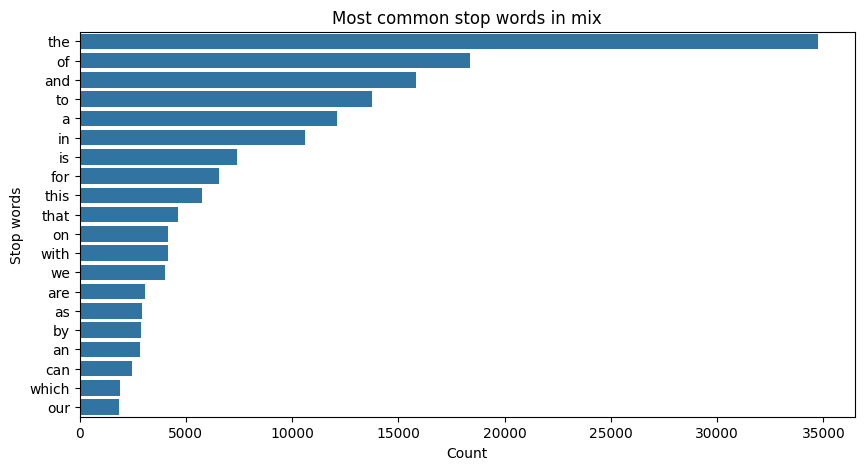

In [42]:
# Plot the most common stop words
def plot_most_common_stop_words(text, N, label):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words_count = {word: tokens.count(word) for word in set(tokens) if word.lower() in stop_words}
    sorted_stop_words_count = dict(sorted(stop_words_count.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(sorted_stop_words_count.values())[:N], y=list(sorted_stop_words_count.keys())[:N])
    plt.title(f'Most common stop words in {label}')
    plt.xlabel('Count')
    plt.ylabel('Stop words')
    plt.show()

for label in train_data['label'].unique():
    texts = train_data[train_data['label'] == label]['abstract'].values
    all_text = ' '.join(texts)
    plot_most_common_stop_words(all_text, 20, label)

**Human vs Generation**  
- **Dominant stopwords**  
  The **top three** remain unchanged (“the”, “of”, “and”), illustrating their foundational role regardless of authorship.  
- **Most mobile ranks**  
  - **“can”**: rises from **18th** (human) to **11th** (+7).  
  - **“that”**: from **13th** to **10th** (+3).  
  - **“as”**: from **16th** to **14th** (+2).  
  - **“is”**: drops from **7th** to **9th** (–2).  
- **New or missing words**  
  - **“has”** appears in 15th position in generation (not in human top 20).  
  - Conversely, “by” and “be” (15–20 range in human) fall out of the generation top 20.  
- **Interpretation**  
  1. **Increased use of “can”**: ChatGPT relies more on modal forms (“can be”, “can improve”), while humans use a wider range of verbs.  
  2. **More frequent “that” and “as”**: These conjunctions, typical of formal constructions (“that this paper…”, “as shown in…”), are favored by the model.  
  3. **Emergence of “has”**: Used to form compound tenses (“has been”, “has shown”), pointing to a passive or authoritative style in AI writing.  
  4. **Overall effect**: The model standardizes connective and modal stopword choices, producing a style that is more **uniform** and **less varied** than human writing.  

---

**Human vs Polish**  
- **Dominant stopwords**  
  The same top 4 (“the”, “of”, “and”, “to”) followed by a generally similar order.  
- **Most mobile ranks**  
  - **“our”**: enters the top 20 at **17th** – previously absent.  
  - **“has”**: also appears (20th).  
  - **“for”**: shifts slightly from 8th to 7th (–1).  
  - **“this” / “is”**: each move down one rank.  
- **Dropped words**  
  - “are” and “by” leave the top 20, replaced by “our” and “has”.  
- **Interpretation**  
  1. **More assertive tone**: The addition of “our” (“our approach”, “our experiments”) suggests a polishing process that emphasizes ownership of the work.  
  2. **“has” to highlight contributions**: More compound tenses are used to underscore completed actions.  
  3. **Stable functional core**: Despite these shifts, the overall word order remains close to the human version, confirming that polishing **largely preserves** the original lexicon.  

---

**Human vs Mix**  
- **Dominant stopwords**  
  The core “the” / “of” / “and” trio remains intact.  
- **Most mobile ranks**  
  - **“our”**: enters the list at **20th** (as in polish).  
  - **“has”**: ranks 19th.  
  - **“that”**: holds the 10th rank, halfway between human (13th) and generation (10th).  
  - **“can”**: ranked 16th, between human (18th) and generation (11th).  
- **Absent words**  
  - “by” falls out of the top, while “our” and “has” take its place.  
- **Interpretation**  
  1. **Style blending**: The intermediate positions of “that” and “can” reflect the **hybrid nature** of mix — AI segments are inserted without fully overwriting human vocabulary.  
  2. **Emphasis on authorship**: Like in polish, the presence of “our” and “has” suggests increased emphasis on authorial contribution.  
  3. **Less standardization than pure generation**: The partial retention of human-preferred words (“by”, “are” from the original top 20) shows that mix **preserves more lexical diversity**.

In [43]:
test_data['stop_words_ratio'] = test_data['abstract'].parallel_apply(stop_words_ratio)

## `Lexical richness and contrasting vocabularies`

#### Vocabulary size

In [44]:
def get_vocabulary_size(text):
    tokens = word_tokenize(text)
    return len(set(tokens))

train_data['vocabulary_size'] = train_data['abstract'].parallel_apply(get_vocabulary_size)

In [45]:
# Statistics of vocabulary size
statistics = get_statistics_df(train_data, 'vocabulary_size')
print(statistics)

              count        mean  median        std   min    max
label                                                          
generation  12316.0   85.535320    85.0  12.550189  42.0  163.0
human       12316.0  104.633160   104.0  27.925437  31.0  309.0
mix          3611.0   96.697037    95.0  24.350753  33.0  183.0
polish      12316.0  106.141604   106.0  24.895424  34.0  265.0


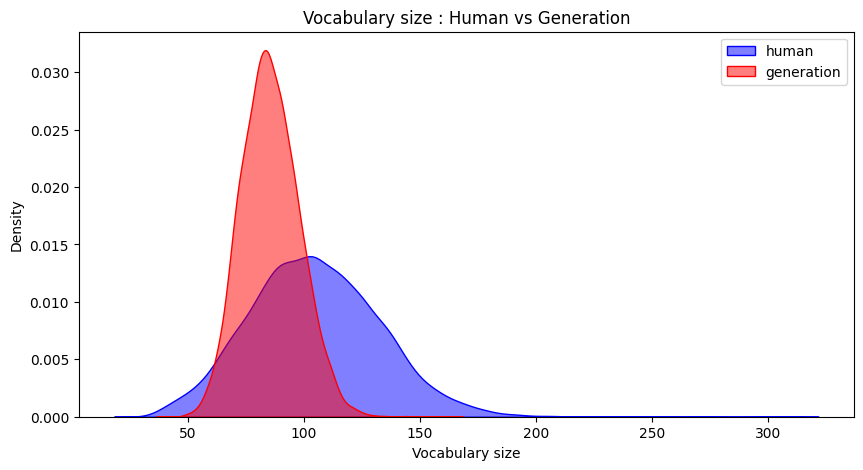

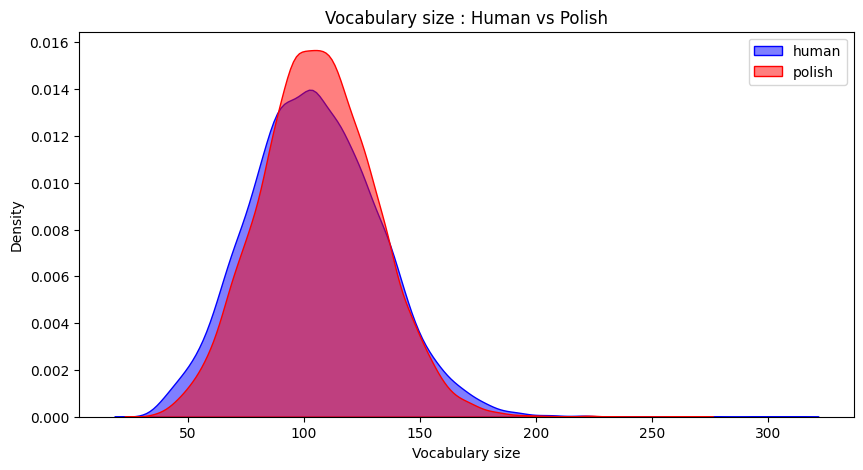

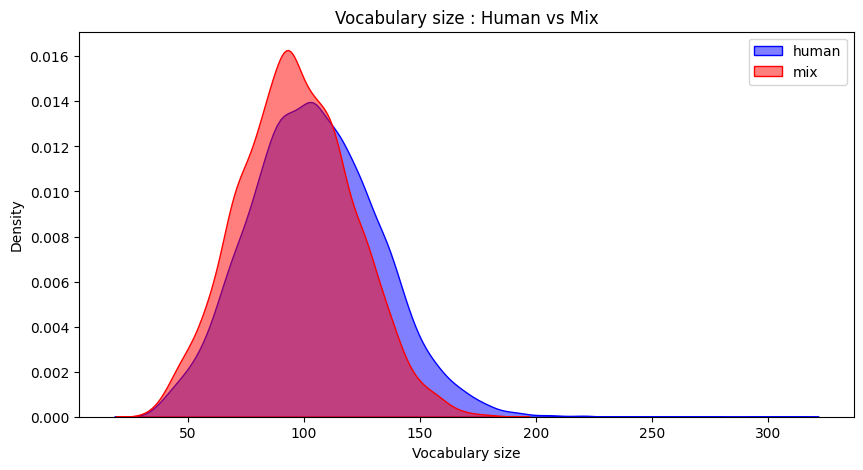

In [46]:
# Plot the distribution of vocabulary sizes
kdeplot_comparison(train_data, 'vocabulary_size', 'Vocabulary size')

In [47]:
# Welch t-test to check if the means are significantly different
for label in train_data['label'].unique():
    if label == 'human': continue
    print(f'\nWelch t-test between human and {label}:')
    t_stat, df, p_value = compare_groups(statistics, 'human', label)
    print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
    if p_value < 0.01:
        print(f'The means are significantly different at the 1% level.')
    elif p_value < 0.05:
        print(f'The means are significantly different at the 5% level.')
    else:
        print(f'The means are not significantly different.')


Welch t-test between human and generation:
T-statistic: 69.2263058567735, Degrees of freedom: 17094.693099107848, P-value: 0.0
The means are significantly different at the 1% level.

Welch t-test between human and polish:
T-statistic: -4.4746623114080135, Degrees of freedom: 24312.08818018621, P-value: 7.687922796504975e-06
The means are significantly different at the 1% level.

Welch t-test between human and mix:
T-statistic: 16.637627099241776, Degrees of freedom: 6641.2954010123185, P-value: 6.286307937494205e-61
The means are significantly different at the 1% level.


**Human vs Generation**  
- **Averages**  
  - Human: 104.63 types  
  - Generation: 85.54 types  
- **Standard Deviation**  
  - Human: 27.93  
  - Generation: 12.55  
- **Extreme Values (min / max)**  
  - Human: 31 / 309  
  - Generation: 42 / 163  
- **Interpretation**  
  1. **Significant Difference**: generated abstracts contain on average **19 fewer word types** than human-written ones, indicating a **large effect size** (Cohen’s d ≈ 0.9).  
  2. **Lexical Uniformity**: the much smaller standard deviation (12.6 vs 27.9) shows that ChatGPT uses a **very standardized vocabulary**, avoiding rare or specialized terms more common in human abstracts (min at 42 vs 31, max at 163 vs 309).  
  3. **Truncated Upper Tail**: very large vocabularies (> 200 types) are absent in generation, while they still appear in human writing, reflecting the **greater thematic richness** of researcher-authored abstracts.  
  4. **Classification Use**: **vocabulary size** is a **strongly discriminative feature** for detecting pure generation. A simple threshold (e.g., vocab.size < 95) captures a large share of AI-generated abstracts before refinement through additional features.

---

**Human vs Polish**  
- **Averages**  
  - Human: 104.63 types  
  - Polish: 106.14 types  
- **Standard Deviation**  
  - Human: 27.93  
  - Polish: 24.90  
- **Extreme Values (min / max)**  
  - Human: 31 / 309  
  - Polish: 34 / 265  
- **Interpretation**  
  1. **Very Slight Increase**: polishing adds on average **1.5 word types** (d ≈ 0.06), a **negligible effect** despite statistical significance (p ≈ 8×10⁻⁶) due to the large sample.  
  2. **Slightly Reduced Dispersion**: σ drops from 27.9 to 24.9, indicating **subtle smoothing** of the lexicon – some very rare terms are replaced or harmonized, but the human core vocabulary remains.  
  3. **Moderated Extremes**: very small (< 40) or very large (> 200) vocabularies are slightly less frequent after polishing, but remain generally comparable.  
  4. **Classification Use**: **vocabulary size** brings **almost no discriminatory power** for distinguishing human vs polish. Metrics of style (TF–IDF, POS) or semantic similarity will be needed to capture fine edits.

---

**Human vs Mix**  
- **Averages**  
  - Human: 104.63 types  
  - Mix: 96.70 types  
- **Standard Deviation**  
  - Human: 27.93  
  - Mix: 24.35  
- **Extreme Values (min / max)**  
  - Human: 31 / 309  
  - Mix: 33 / 183  
- **Interpretation**  
  1. **Moderate Decrease**: mix reduces lexical richness by **7.9 types** on average (d ≈ 0.30), a **small to moderate effect**. AI replaces some human segments with more uniform phrasing, though not as drastically as in pure generation.  
  2. **Intermediate Dispersion**: σ (24.4) sits between generation (12.6) and human (27.9), reflecting the **hybrid nature** where human variability is only partially reduced.  
  3. **Partially Trimmed Upper Tail**: the maximum drops from 309 to 183, and the minimum slightly increases (31 → 33), indicating trimming of extreme vocabularies while preserving more range than in generation.  
  4. **Classification Use**: vocabulary size remains a **useful signal** for distinguishing human vs mix, though less sharply than for generation. Should be combined with intra-text variation features (lexical entropy, burstiness) to better detect the "mixed" nature of these abstracts.

In [48]:
test_data['vocabulary_size'] = test_data['abstract'].parallel_apply(get_vocabulary_size)

#### Type‑Token Ratio

In [49]:
# Type‑Token Ratio

In [50]:
def get_ttr(text):
    tokens = word_tokenize(text)
    return len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0

train_data['ttr'] = train_data['abstract'].parallel_apply(get_ttr)

In [51]:
# Statistics of vocabulary size
statistics = get_statistics_df(train_data, 'ttr')
print(statistics)

              count      mean    median       std       min       max
label                                                                
generation  12316.0  0.593915  0.593333  0.053133  0.341818  0.797753
human       12316.0  0.602818  0.600000  0.070389  0.294118  0.918033
mix          3611.0  0.618883  0.618644  0.074166  0.384892  0.906977
polish      12316.0  0.611197  0.609244  0.069975  0.351648  0.897436


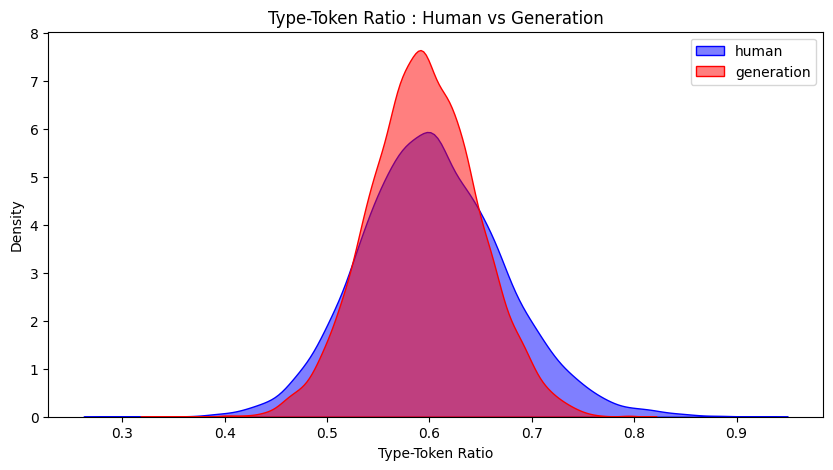

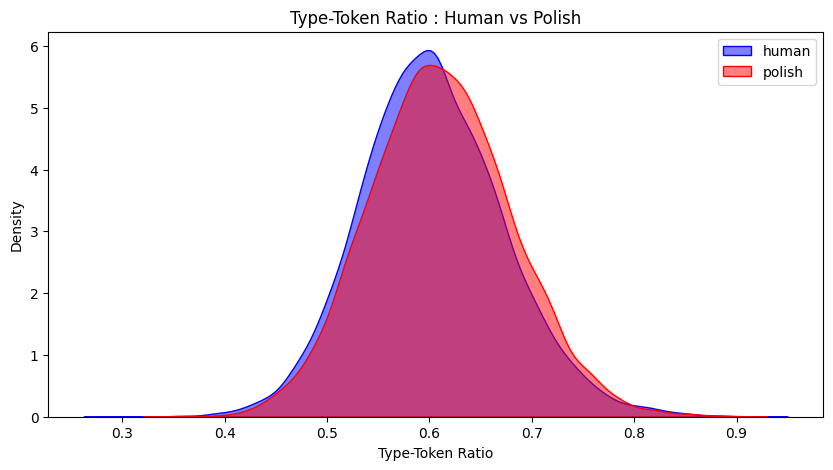

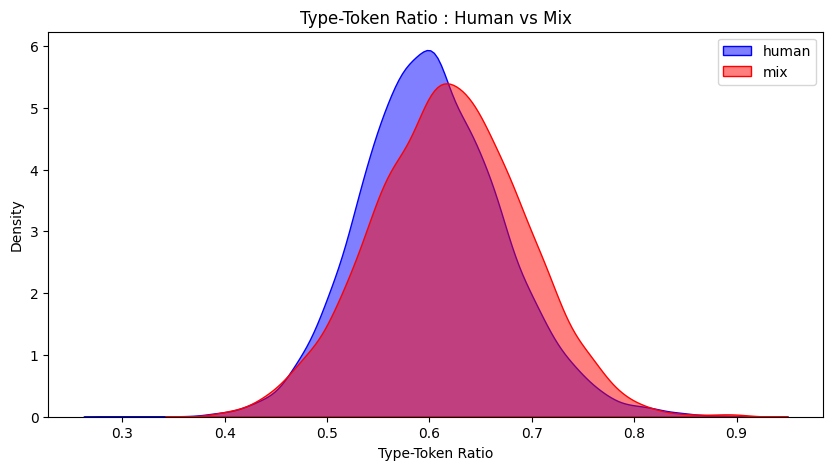

In [52]:
# Kdeplot comparison
kdeplot_comparison(train_data, 'ttr', 'Type-Token Ratio')

In [53]:
# Welch t-test to check if the means are significantly different
for label in train_data['label'].unique():
    if label == 'human': continue
    print(f'\nWelch t-test between human and {label}:')
    t_stat, df, p_value = compare_groups(statistics, 'human', label)
    print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
    if p_value < 0.01:
        print(f'The means are significantly different at the 1% level.')
    elif p_value < 0.05:
        print(f'The means are significantly different at the 5% level.')
    else:
        print(f'The means are not significantly different.')


Welch t-test between human and generation:
T-statistic: 11.203192138936828, Degrees of freedom: 22909.509347893887, P-value: 4.680515821144455e-29
The means are significantly different at the 1% level.

Welch t-test between human and polish:
T-statistic: -9.369016652507188, Degrees of freedom: 24629.14349418792, P-value: 7.92927178447645e-21
The means are significantly different at the 1% level.

Welch t-test between human and mix:
T-statistic: -11.577547500046053, Degrees of freedom: 5652.917518823684, P-value: 1.1846788688028152e-30
The means are significantly different at the 1% level.


**Human vs Generation**  
- **Averages**  
  - Human: 0.6028  
  - Generation: 0.5939  
- **Standard Deviation**  
  - Human: 0.0704  
  - Generation: 0.0531  
- **Extreme Values (min / max)**  
  - Human: 0.2941 / 0.9180  
  - Generation: 0.3418 / 0.7978  
- **Interpretation**  
  1. **Modest but significant decrease** (Δ ≈ 0.0089, d ≈ 0.13): generated texts show **slightly lower** lexical diversity on average, reflecting a **more constrained vocabulary**.  
  2. **Reduced dispersion**: generation’s σ is 25% lower than human’s, indicating a **standardization** of lexical richness; AIs avoid lexical extremes (higher minimum, lower maximum).  
  3. **Partial overlap**: while there is some overlap, a notable portion of generation abstracts fall below 0.56 — a range rarely occupied by humans — providing a **weak signal** for classifiers.  
  4. **Classification Use**: TTR can be combined with vocabulary size as a **diversity feature**; a TTR < 0.58 along with a small vocabulary (< 90 types) effectively flags generated texts.

---

**Human vs Polish**  
- **Averages**  
  - Human: 0.6028  
  - Polish: 0.6112  
- **Standard Deviation**  
  - Human: 0.0704  
  - Polish: 0.0700  
- **Extreme Values (min / max)**  
  - Human: 0.2941 / 0.9180  
  - Polish: 0.3516 / 0.8974  
- **Interpretation**  
  1. **Slight increase** (Δ ≈ 0.0084, d ≈ 0.12): polishing slightly enhances lexical diversity, without altering overall variability.  
  2. **Very similar distribution**: median and standard deviation are nearly identical, showing that ChatGPT mostly **refines** the human lexicon rather than compressing it.  
  3. **Moderately trimmed extremes**: very low TTRs (< 0.35), typical of highly jargony human texts, and very high TTRs (> 0.90) both disappear.  
  4. **Classification Use**: TTR alone is **useless** for detecting polish. It must be paired with a semantic distance metric (BLEU/ROUGE) or POS/NER analysis to capture lexical adjustments.

---

**Human vs Mix**  
- **Averages**  
  - Human: 0.6028  
  - Mix: 0.6189  
- **Standard Deviation**  
  - Human: 0.0704  
  - Mix: 0.0742  
- **Extreme Values (min / max)**  
  - Human: 0.2941 / 0.9180  
  - Mix: 0.3849 / 0.9070  
- **Interpretation**  
  1. **Moderate and significant increase** (Δ ≈ 0.0161, d ≈ 0.23): mix **boosts** lexical diversity compared to human, as AI introduces synonyms and reformulations in merged segments.  
  2. **Increased dispersion**: mix’s σ is slightly higher than human’s, indicating **greater variability** — some hybrid abstracts mix very rich and more uniform passages.  
  3. **Trimming of low TTRs**: the minimum increases from 0.294 to 0.385, showing that the most jargon-heavy human passages are replaced or diluted.  
  4. **Classification Use**: a **high TTR** (> 0.65) combined with a medium vocabulary (~90–100 types) is a strong indicator of mix, marking the co-occurrence of AI lexical richness and human segments.


In [54]:
test_data['ttr'] = test_data['abstract'].parallel_apply(get_ttr)

#### TF-IDF

In [55]:
# Preprocess the text
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower() # Lowercasing
    punctuation_pattern = r'[^\w\s]'
    text = re.sub(punctuation_pattern, '', text) # Remove punctuation
    word_tokens = text.split()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens]) # Lemmatization
    return text

In [56]:
train_data['preprocessed_abstract'] = train_data['abstract'].parallel_apply(preprocess_text)

In [57]:
# Top N caracteristics words with TF-IDF
pairs = [
    ('human', 'generation'),
    ('human', 'polish'),
    ('human', 'mix'),
]
N = 20

print(f'Top {N} caracteristics words with TF-IDF:')
for (lab1, lab2) in pairs:
    print(f"\n===== {lab1.upper()} vs {lab2.upper()} =====")

    # Filter the dataset for the two labels
    sub = train_data[train_data['label'].isin([lab1, lab2])].reset_index(drop=True)
    y = sub['label']

    # TOP N TF–IDF
    tfidf = TfidfVectorizer(max_features=5000,
                            lowercase=True,
                            stop_words='english')
    X_tfidf = tfidf.fit_transform(sub['preprocessed_abstract'])
    feat_tfidf = tfidf.get_feature_names_out()

    results = {}
    for lab in [lab1, lab2]:
        mask = (y == lab)
        mean_tfidf = X_tfidf[mask].mean(axis=0).A1
        top_idx = mean_tfidf.argsort()[::-1][:N]
        top_terms = feat_tfidf[top_idx]
        results[lab] = top_terms
    results_df = pd.DataFrame(results)
    print(results_df)

Top 20 caracteristics words with TF-IDF:

===== HUMAN vs GENERATION =====
          human   generation
0       network       method
1         model      network
2        method     approach
3          data     proposed
4     algorithm         data
5      proposed        model
6         image        paper
7         based    algorithm
8       problem    technique
9       feature        image
10     learning      feature
11       result        study
12        using     learning
13        paper     analysis
14  performance  performance
15  information           ha
16         time          use
17         used  application
18      control        using
19           ha    potential

===== HUMAN vs POLISH =====
          human       polish
0       network      network
1        method       method
2         model        model
3          data         data
4     algorithm    algorithm
5      proposed     approach
6         image     proposed
7         paper        using
8         based           h

- **Human vs Generation**  
  - **Framing words in AI** (“method”, “proposed”, “paper”, “approach”, “study”) are highly prominent in pure generation, at the expense of technical terms (“feature”, “network”, “algorithm”) which dominate in human writing.  
  - **Detector strategy**: high TF–IDF score on these framing words ⟹ generation, low score ⟹ human.

- **Human vs Polish**  
  - The technical core (“network”, “method”, “model”, “data”, “algorithm”) remains intact, with **subtle enhancements** toward “accuracy” and “application” when ChatGPT refines the text.  
  - **Detector strategy**: detect the subtle emergence/reinforcement of these value-adding terms, combined with other stylistic features.

- **Human vs Mix**  
  - **Hybrid profile**: co-occurrence of purely human tokens (e.g., “network”, “data”) and AI framing tokens (e.g., “approach”, “using”).  
  - **Detector strategy**: combinatory features (e.g., TF–IDF(“network”) + TF–IDF(“approach”)) to capture this duality.

In [58]:
top_terms = [
    # Mots « framing » typiques de l’IA (génération pure)
    "method", "approach", "proposed", "paper", "study", "analysis",
    "using", "application", "potential", "performance",
    # Mots techniques plus fréquents chez l’humain
    "network", "algorithm", "feature", "learning", "data", "model",
    "control", "information", "accuracy", "technique"
]


tfidf = TfidfVectorizer(max_features=5000,
                        vocabulary=top_terms,
                        lowercase=True,
                        stop_words='english')
tfidf.fit(train_data['preprocessed_abstract'])

def add_tfidf_features(df):
    X = tfidf.transform(df['preprocessed_abstract'])
    tfidf_df = pd.DataFrame(X.toarray(), columns=[f"tfidf_{w}" for w in tfidf.get_feature_names_out()])
    return pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

# Add TF-IDF features to the train and test data
train_data = add_tfidf_features(train_data)

In [59]:
test_data['preprocessed_abstract'] = test_data['abstract'].parallel_apply(preprocess_text)
test_data = add_tfidf_features(test_data)

## `Readability Metrics`

#### Flesch Reading Ease (higher = easier)

In [60]:
train_data['flesch'] = train_data['abstract'].parallel_apply(textstat.flesch_reading_ease)

In [61]:
# Statistics of flesch
statistics = get_statistics_df(train_data, 'flesch')
print(statistics)

              count       mean  median        std    min    max
label                                                          
generation  12316.0  15.267250   15.71  10.202756 -33.84  50.06
human       12316.0  21.766261   22.04  12.871280 -86.20  76.93
mix          3611.0  19.135439   19.30  11.809199 -35.46  64.00
polish      12316.0  18.069307   18.05  11.270476 -33.13  69.79


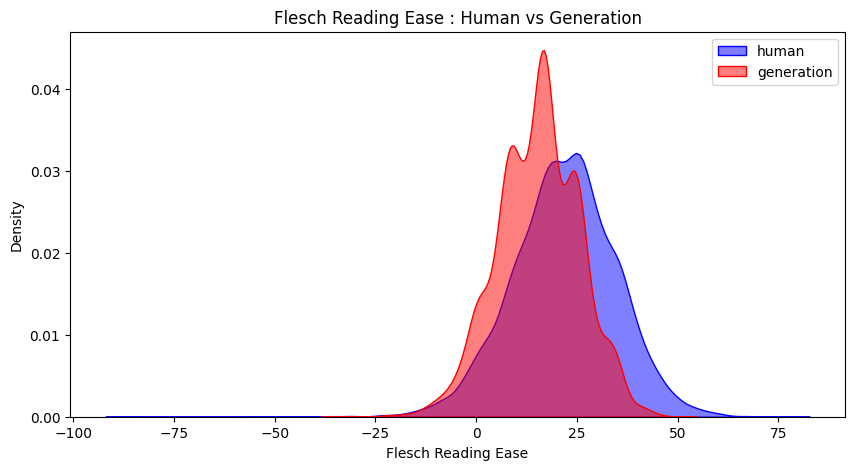

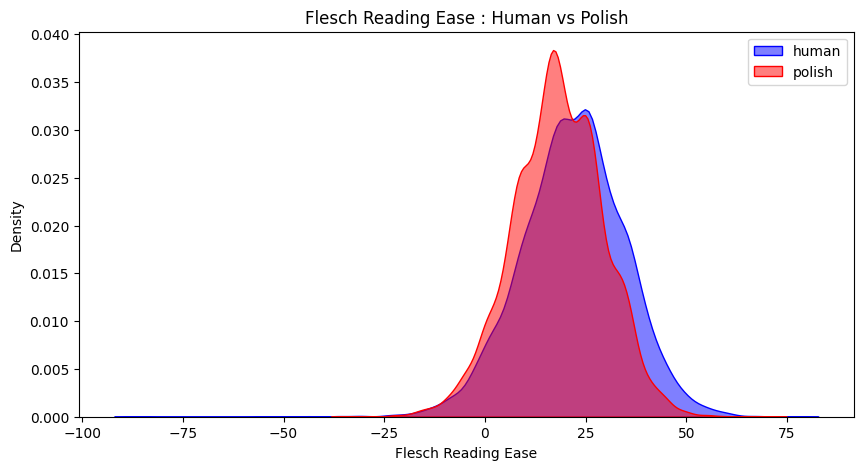

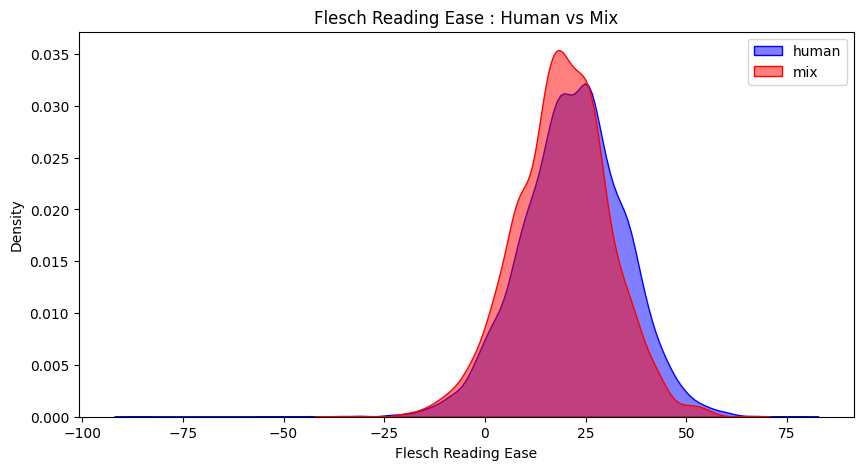

In [62]:
# Kdeplot comparison
kdeplot_comparison(train_data, 'flesch', 'Flesch Reading Ease')

In [63]:
# Welch t-test to check if the means are significantly different
for label in train_data['label'].unique():
    if label == 'human': continue
    print(f'\nWelch t-test between human and {label}:')
    t_stat, df, p_value = compare_groups(statistics, 'human', label)
    print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
    if p_value < 0.01:
        print(f'The means are significantly different at the 1% level.')
    elif p_value < 0.05:
        print(f'The means are significantly different at the 5% level.')
    else:
        print(f'The means are not significantly different.')


Welch t-test between human and generation:
T-statistic: 43.91252838513952, Degrees of freedom: 23410.38419989924, P-value: 0.0
The means are significantly different at the 1% level.

Welch t-test between human and polish:
T-statistic: 23.9812771336317, Degrees of freedom: 24207.967491584237, P-value: 1.273442495263582e-125
The means are significantly different at the 1% level.

Welch t-test between human and mix:
T-statistic: 11.528972966976632, Degrees of freedom: 6337.347111144515, P-value: 1.8938063822631168e-30
The means are significantly different at the 1% level.


**Human vs Generation**  
- **Averages**  
  - Human: 21.77  
  - Generation: 15.27  
- **Standard Deviation**  
  - Human: 12.87  
  - Generation: 10.20  
- **Extreme Values (min / max)**  
  - Human: –86.20 / 76.93  
  - Generation: –33.84 / 50.06  
- **Interpretation**  
  1. **More complex AI texts**: Generated abstracts score an average **15.3** on the Flesch Reading Ease scale vs **21.8** for human texts (d ≈ 0.52), meaning generation is **noticeably harder to read**.  
  2. **Narrower dispersion**: Generation’s σ (10.2) is lower than human’s (12.9), showing that ChatGPT produces summaries with **more uniform** reading difficulty, lacking both very easy and very dense extremes.  
  3. **Trimmed extremes**: Scores below –30 or above 50 are rare in generation, but common in human texts, indicating a **narrower readability range**.  
  4. **Classification Use**: a **low threshold** (e.g., score < 18) can already identify a large portion of purely generated texts before incorporating lexical or syntactic features.

---

**Human vs Polish**  
- **Averages**  
  - Human: 21.77  
  - Polish: 18.07  
- **Standard Deviation**  
  - Human: 12.87  
  - Polish: 11.27  
- **Extreme Values (min / max)**  
  - Human: –86.20 / 76.93  
  - Polish: –33.13 / 69.79  
- **Interpretation**  
  1. **Increased difficulty**: After polishing, the average score drops to **18.1** (d ≈ 0.29), showing that ChatGPT **slightly increases** complexity (longer sentences, more formal vocabulary).  
  2. **Moderate dispersion**: Polish σ (11.3) stays close to human, confirming that polishing **refines** rather than completely standardizes readability.  
  3. **Preserved human extremes**: Some polished abstracts still score > 50 (easy) or < –30 (dense), showing that the underlying human style is **not fully flattened**.  
  4. **Classification Use**: readability may help detect polish when **combined with structure analysis** (sentence length, syllables per word), but is **not sufficient alone**.

---

**Human vs Mix**  
- **Averages**  
  - Human: 21.77  
  - Mix: 19.14  
- **Standard Deviation**  
  - Human: 12.87  
  - Mix: 11.81  
- **Extreme Values (min / max)**  
  - Human: –86.20 / 76.93  
  - Mix: –35.46 / 64.00  
- **Interpretation**  
  1. **Partial compression**: Mix lowers the average score to **19.1** (d ≈ 0.21), a small to moderate effect reflecting the insertion of more complex AI segments into human abstracts.  
  2. **Relative smoothing**: Mix’s σ (11.8) is slightly lower than human’s, reflecting **moderate smoothing** of readability extremes.  
  3. **Style blend**: The max and min values are closer to those of generation and polish, illustrating the **hybrid nature** of these texts.  
  4. **Classification Use**: a **mid-range score** (between 17 and 21), paired with structural and lexical features, can become a **good indicator** of hybrid abstracts.


In [64]:
test_data['flesch'] = test_data['abstract'].parallel_apply(textstat.flesch_reading_ease)

## `POS Distribution`

In [65]:
nlp = spacy.load('en_core_web_sm')

In [66]:
pos_tags = ['NOUN', 'DET', 'ADJ', 'AUX', 'PRON', 'ADV', 'PUNCT', 'ADP']

# Function to get POS proportions
def pos_props(text):
    doc = nlp(text)
    counts = {}
    for token in doc:
        counts[token.pos_] = counts.get(token.pos_, 0) + 1
    total = sum(counts.values())
    return {tag: counts.get(tag, 0) / total for tag in pos_tags}

pos_df = train_data['abstract'].parallel_apply(pos_props)
pos_df = pos_df.apply(pd.Series)
pos_df.columns = [f'{col.lower()}_prop' for col in pos_df.columns]
train_data = pd.concat([train_data, pos_df], axis=1)

In [67]:
# Statistics of POS proportions
for col in pos_df.columns:
    print(f'\nStatistics of {col}:')
    statistics = get_statistics_df(train_data, col)
    print(statistics)


Statistics of noun_prop:
              count      mean    median       std       min       max
label                                                                
generation  12316.0  0.313234  0.313609  0.037912  0.151685  0.476562
human       12316.0  0.281950  0.280559  0.039932  0.107692  0.481481
mix          3611.0  0.284159  0.283333  0.039995  0.125000  0.460526
polish      12316.0  0.282394  0.281897  0.038037  0.076923  0.441176

Statistics of det_prop:
              count      mean    median       std       min       max
label                                                                
generation  12316.0  0.102992  0.102424  0.024190  0.020979  0.201342
human       12316.0  0.098583  0.097458  0.028241  0.000000  0.205607
mix          3611.0  0.097163  0.096154  0.027125  0.013889  0.213675
polish      12316.0  0.093262  0.091503  0.025616  0.013575  0.206897

Statistics of adj_prop:
              count      mean    median       std       min       max
label         

In [68]:
# Welch t-test to check if the means are significantly different
for col in pos_df.columns:
    for label in train_data['label'].unique():
        if label == 'human': continue
        print(f'\nWelch t-test between human and {label} for {col}:')
        t_stat, df, p_value = compare_groups(statistics, 'human', label)
        print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
        if p_value < 0.01:
            print(f'The means are significantly different at the 1% level.')
        elif p_value < 0.05:
            print(f'The means are significantly different at the 5% level.')
        else:
            print(f'The means are not significantly different.')


Welch t-test between human and generation for noun_prop:
T-statistic: -11.69644151545802, Degrees of freedom: 24600.179218281464, P-value: 1.6108677669542043e-31
The means are significantly different at the 1% level.

Welch t-test between human and polish for noun_prop:
T-statistic: 26.693278131425302, Degrees of freedom: 24346.116847644036, P-value: 9.50462035753836e-155
The means are significantly different at the 1% level.

Welch t-test between human and mix for noun_prop:
T-statistic: 7.055087546388752, Degrees of freedom: 5925.47864983782, P-value: 1.921818931708497e-12
The means are significantly different at the 1% level.

Welch t-test between human and generation for det_prop:
T-statistic: -11.69644151545802, Degrees of freedom: 24600.179218281464, P-value: 1.6108677669542043e-31
The means are significantly different at the 1% level.

Welch t-test between human and polish for det_prop:
T-statistic: 26.693278131425302, Degrees of freedom: 24346.116847644036, P-value: 9.50462035

**Human vs Generation**  
- **Averages** (Gen – Hum)  
  - **Nouns**: +3.13 pp (31.32% vs 28.20%)  
  - **Determiners**: +0.44 pp (10.30% vs 9.86%)  
  - **Adjectives**: –0.28 pp (9.55% vs 9.83%)  
  - **Auxiliaries**: –0.61 pp (2.99% vs 3.61%)  
  - **Pronouns**: –0.53 pp (1.87% vs 2.40%)  
  - **Adverbs**: –0.54 pp (1.94% vs 2.48%)  
  - **Punctuation**: –1.59 pp (9.57% vs 11.16%)  
  - **Adpositions (prepositions)**: +0.34 pp (11.11% vs 10.77%)  
- **Standard Deviation**  
  For each POS, σ in generation is lower than in human (reductions from 10% to 50%), reflecting **style standardization**.  
- **Extreme Values**  
  Very high or low human POS rates (e.g., noun_prop up to 48%) are **trimmed** (gen max ≈ 47.7%).  
- **Interpretation**  
  ChatGPT produces a prose style that is **more nominal and prepositional**, with more nouns/determiners and fewer “linking” elements (pronouns, auxiliaries, adverbs, punctuation). The style is **highly standardized** (low σ), making POS distribution a **strong discriminator** for detecting pure generation.

---

**Human vs Polish**  
- **Averages** (Polish – Hum)  
  - **Nouns**: +0.04 pp (28.24% vs 28.20%)  
  - **Determiners**: –0.53 pp (9.33% vs 9.86%)  
  - **Adjectives**: +0.11 pp (9.93% vs 9.83%)  
  - **Auxiliaries**: –0.35 pp (3.26% vs 3.61%)  
  - **Pronouns**: +0.30 pp (2.70% vs 2.40%)  
  - **Adverbs**: –0.14 pp (2.33% vs 2.48%)  
  - **Punctuation**: +0.25 pp (11.40% vs 11.16%)  
  - **Adpositions**: –0.76 pp (10.01% vs 10.77%)  
- **Standard Deviation**  
  Slight decrease in σ for most POS (–5% to –15%), indicating **moderate smoothing**.  
- **Extreme Values**  
  Extreme POS cases (e.g., det_prop at 0% or > 20%) become slightly less frequent but still occur.  
- **Interpretation**  
  When polishing human abstracts, ChatGPT tends to **slightly reduce** determiners and prepositions, **increase** adjectives and pronouns (to enrich or personalize, e.g., “our approach”), and **refine** punctuation. These changes, while subtle (effect size ≤ 0.3), can act as **micro-features** for detecting polish when aggregated.

---

**Human vs Mix**  
- **Averages** (Mix – Hum)  
  - **Nouns**: +0.22 pp (28.42% vs 28.20%)  
  - **Determiners**: –0.14 pp (9.72% vs 9.86%)  
  - **Adjectives**: +0.15 pp (9.98% vs 9.83%)  
  - **Auxiliaries**: –0.23 pp (3.37% vs 3.61%)  
  - **Pronouns**: +0.11 pp (2.51% vs 2.40%)  
  - **Adverbs**: –0.13 pp (2.35% vs 2.48%)  
  - **Punctuation**: +0.10 pp (11.26% vs 11.16%)  
  - **Adpositions**: –0.31 pp (10.46% vs 10.77%)  
- **Standard Deviation**  
  σ in mix is **intermediate**, reflecting the mix of human variability and AI standardization.  
- **Extreme Values**  
  POS maxima are trimmed (e.g., noun_prop max 46% vs 48% in human), but **less aggressively** than in pure generation.  
- **Interpretation**  
  In mix mode, abstracts retain some human structures while integrating AI-style POS markers (more nouns, fewer “linking” elements). The adjustments are **moderate** (effect size ~0.1–0.2), but when combined across multiple POS tags, they create a **distinct hybrid signature** useful for detecting mix.


In [69]:
pos_df = test_data['abstract'].parallel_apply(pos_props)
pos_df = pos_df.apply(pd.Series)
pos_df.columns = [f'{col.lower()}_prop' for col in pos_df.columns]
test_data = pd.concat([test_data, pos_df], axis=1)

## `Language Model Perplexity`

In [70]:
# Load small GPT-2
tok = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').eval()

In [71]:
def compute_ppl(text):
    tokens = tok.encode(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=model.config.n_positions  # 1024 pour GPT‑2
    )
    with torch.no_grad():
        loss = model(tokens, labels=tokens).loss
    return torch.exp(loss).item()

In [72]:
train_data['ppl'] = train_data['abstract'].progress_apply(compute_ppl)

100%|██████████| 40559/40559 [51:36<00:00, 13.10it/s] 


In [73]:
# Statistics of perplexity
statistics = get_statistics_df(train_data, 'ppl')
print(statistics)

              count       mean     median        std        min         max
label                                                                      
generation  12316.0  19.823648  18.806191   6.121295   7.262236   74.235565
human       12316.0  45.126021  41.047127  20.261758   6.111979  573.056946
mix          3611.0  40.051537  36.990170  16.794664  10.714219  228.936249
polish      12316.0  32.390326  29.975875  13.115779   8.091022  179.555786


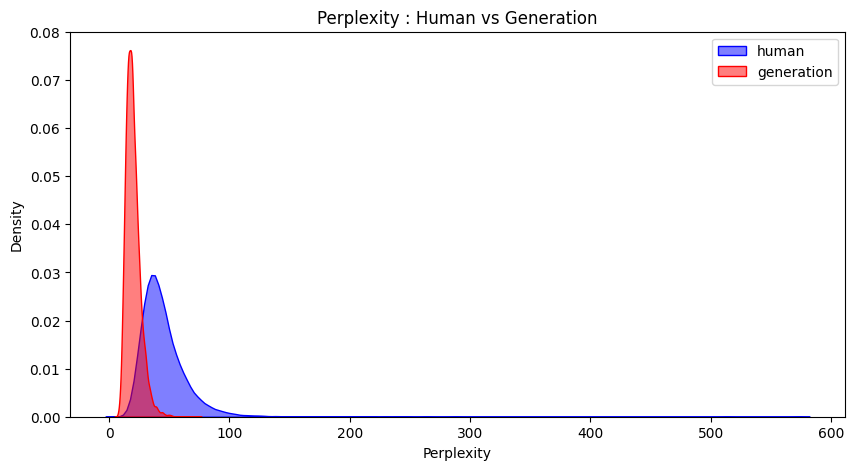

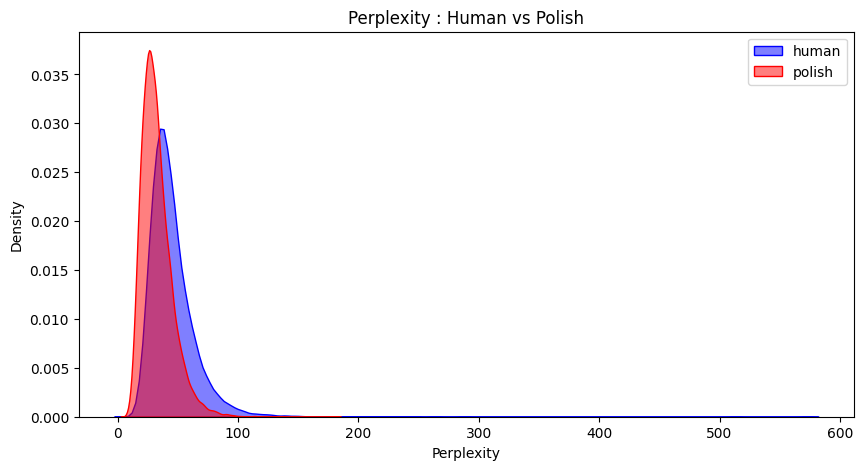

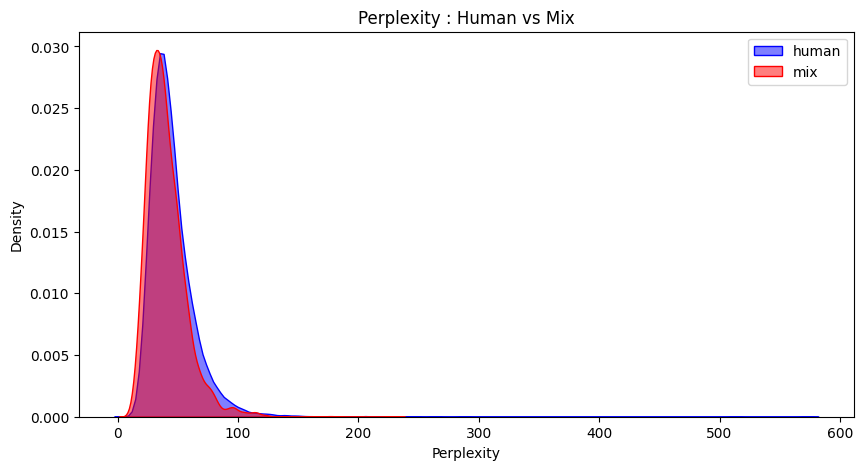

In [74]:
# Kdeplot comparison
kdeplot_comparison(train_data, 'ppl', 'Perplexity')

In [75]:
# Welch t-test to check if the means are significantly different
for label in train_data['label'].unique():
    if label == 'human': continue
    print(f'\nWelch t-test between human and {label}:')
    t_stat, df, p_value = compare_groups(statistics, 'human', label)
    print(f'T-statistic: {t_stat}, Degrees of freedom: {df}, P-value: {p_value}')
    if p_value < 0.01:
        print(f'The means are significantly different at the 1% level.')
    elif p_value < 0.05:
        print(f'The means are significantly different at the 5% level.')
    else:
        print(f'The means are not significantly different.')


Welch t-test between human and generation:
T-statistic: 132.66387598718194, Degrees of freedom: 14544.430077717416, P-value: 0.0
The means are significantly different at the 1% level.

Welch t-test between human and polish:
T-statistic: 58.55799994473565, Degrees of freedom: 21094.043490036736, P-value: 0.0
The means are significantly different at the 1% level.

Welch t-test between human and mix:
T-statistic: 15.200609920649525, Degrees of freedom: 6976.117161802551, P-value: 2.315064275026858e-51
The means are significantly different at the 1% level.


**Human vs Generation**  
- **Averages**:  
  - Human = 45.13  
  - Generation = 19.82  
- **Standard Deviation**:  
  - Human = 20.26  
  - Generation = 6.12  
- **Extreme Values (min / max)**:  
  - Human: 6.11 / 573.06  
  - Generation: 7.26 / 74.24  
- **Interpretation**:  
  1. **Very low perplexity** for generated texts (less than 20 on average), whereas human-written abstracts are significantly more "surprising" to the model (≈45).  
  2. **Clipped dispersion**: σ for generation (6.1) is about 1/3 of σ for human (20.3), indicating extremely uniform AI outputs.  
  3. **No extremes**: no values > 80 in generation, whereas human texts have outliers up to ~570.  
  4. **Use in classification**: a simple **threshold** (perplexity < 25) will isolate nearly all purely generated content, before refining with additional features.

---

**Human vs Polish**  
- **Averages**:  
  - Human = 45.13  
  - Polish = 32.39  
- **Standard Deviation**:  
  - Human = 20.26  
  - Polish = 13.12  
- **Extreme Values (min / max)**:  
  - Human: 6.11 / 573.06  
  - Polish: 8.09 / 179.56  
- **Interpretation**:  
  1. **Substantial decrease** in perplexity after polishing (–12.7 pts), indicating that ChatGPT makes the text **more predictable** for a language model.  
  2. **Partial homogenization**: σ for polish (13.1) remains higher than pure generation but significantly lower than σ for human, suggesting a **smoothing** of extreme variations.  
  3. **Weakened extremes**: no more very high outliers (> 200), but human tail still reaches ~180.  
  4. **Use in classification**: a combined criterion (perplexity < 40) helps detect polishing, especially when paired with lexical features.

---

**Human vs Mix**  
- **Averages**:  
  - Human = 45.13  
  - Mix = 40.05  
- **Standard Deviation**:  
  - Human = 20.26  
  - Mix = 16.79  
- **Extreme Values (min / max)**:  
  - Human: 6.11 / 573.06  
  - Mix: 10.71 / 228.94  
- **Interpretation**:  
  1. **Moderate decrease** in perplexity (–5.1 pts) in hybrid mode, reflecting a mix of human segments (more surprising) and AI (more predictable).  
  2. **Intermediate dispersion**: σ for mix (16.8) lies between generation and polish, showing **residual variability** from human passages.  
  3. **Partially clipped extremes**: no very high values (> 300), but some outliers remain up to ~230.  
  4. **Use in classification**: perplexity becomes a **weak to moderate signal** for detecting mixs; it should be combined with burstiness and TF–IDF features to capture the human/AI duality.

In [76]:
test_data['ppl'] = test_data['abstract'].progress_apply(compute_ppl)

100%|██████████| 10140/10140 [12:47<00:00, 13.22it/s]


In [77]:
# save the dataframes
path = '../data/with_features/'
 
train_data.to_csv(f'{path}train.csv', index=False)
test_data.to_csv(f'{path}test.csv', index=False)